# Approach:

We consider this as logistic regression classification problem. We do the following.

- Exploratory analysis
- One variable regression to understand the importance of a given variable.
- Model building considering the important variables from the above steps.
- Feature enginering(Iterative) to improve the f1-score.

## We are documenting the final results here, for quick reference

- We derive new variables , 'new_deliquency_score' and 'new_credit_score' which are used in the final model. 'new Deliqunecy score' indicates whether loan repayment pattern is improving or not. 'new_credit score' is a average of barrower and co-borrower credit score(if applicable).
- Our final model consists of the following variables. (f1-score 31.52% on test data)
     - "interest_rate","debt_to_income_ratio", "new_cred_score","new_deliquency_score" 
     
## Score for improvement
- SMOT resampling to address imbalanced data
- outlier analysis
- Standardising variables and rebuilding the model.

In [1]:
## We import the standard libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm

In [2]:
loan_df = pd.read_csv("./train_u5jK80M/train.csv");

In [3]:
loan_df.sample(5)

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
26381,413882512872,Y,Browning-Hart,4.125,187000,360,2012-01-01,03/2012,84,1.0,...,0,0,0,0,0,0,0,0,0,0
77339,872173407761,Y,OTHER,3.250,130000,120,2012-02-01,04/2012,65,2.0,...,0,0,0,0,0,0,0,0,0,0
72125,759874454964,X,OTHER,3.875,417000,360,2012-03-01,05/2012,63,2.0,...,0,0,0,0,0,0,0,0,0,0
84795,556351335946,Y,"Turner, Baldwin and Rhodes",4.000,158000,240,2012-01-01,03/2012,93,1.0,...,0,0,0,0,0,0,0,0,0,0
101839,367848803949,Y,Browning-Hart,3.875,400000,360,2012-02-01,04/2012,80,2.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116058 entries, 0 to 116057
Data columns (total 29 columns):
loan_id                     116058 non-null int64
source                      116058 non-null object
financial_institution       116058 non-null object
interest_rate               116058 non-null float64
unpaid_principal_bal        116058 non-null int64
loan_term                   116058 non-null int64
origination_date            116058 non-null object
first_payment_date          116058 non-null object
loan_to_value               116058 non-null int64
number_of_borrowers         116058 non-null float64
debt_to_income_ratio        116058 non-null float64
borrower_credit_score       116058 non-null float64
loan_purpose                116058 non-null object
insurance_percent           116058 non-null float64
co-borrower_credit_score    116058 non-null float64
insurance_type              116058 non-null float64
m1                          116058 non-null int64
m2                  

In [4]:
# We convert origination_date, and first_payment_date to date datatypes
loan_df["origination_date"]= loan_df["origination_date"].apply(pd.to_datetime);
loan_df["first_payment_date"]= loan_df["first_payment_date"].apply(pd.to_datetime);

## Summary Statistics

In [5]:
loan_df.source.unique()

array(['Z', 'Y', 'X'], dtype=object)

In [6]:
round(pd.crosstab(loan_df.source, 
            loan_df.m13,
            normalize ="index")*100,2)

m13,0,1
source,,
X,99.52,0.48
Y,99.34,0.66
Z,99.43,0.57


In [7]:
loan_df.financial_institution.unique()

array(['Turner, Baldwin and Rhodes', 'Swanson, Newton and Miller',
       'Thornton-Davis', 'OTHER', 'Browning-Hart', 'Richardson Ltd',
       'Edwards-Hoffman', 'Richards-Walters', 'Martinez, Duffy and Bird',
       'Miller, Mcclure and Allen', 'Anderson-Taylor',
       'Taylor, Hunt and Rodriguez', 'Nicholson Group',
       'Cole, Brooks and Vincent', 'Sanchez, Hays and Wilkerson',
       'Sanchez-Robinson', 'Suarez Inc', 'Romero, Woods and Johnson',
       'Chapman-Mcmahon'], dtype=object)

In [9]:
round(pd.crosstab(loan_df.financial_institution, 
            loan_df.m13,
            normalize ="index")*100,2)

m13,0,1
financial_institution,,
Anderson-Taylor,99.38,0.62
Browning-Hart,99.45,0.55
Chapman-Mcmahon,100.00,0.00
"Cole, Brooks and Vincent",99.27,0.73
Edwards-Hoffman,99.16,0.84
"Martinez, Duffy and Bird",99.51,0.49
"Miller, Mcclure and Allen",99.40,0.60
Nicholson Group,99.48,0.52
OTHER,99.46,0.54


In [8]:
loan_df.loan_purpose.unique()

array(['C86', 'B12', 'A23'], dtype=object)

In [9]:
round(pd.crosstab(loan_df.loan_purpose, 
            loan_df.m13,
            normalize ="index")*100,2)

m13,0,1
loan_purpose,,
A23,99.64,0.36
B12,99.25,0.75
C86,99.27,0.73


In [10]:
loan_df.insurance_type.unique()

array([0., 1.])

In [11]:
round(pd.crosstab(loan_df.insurance_type, 
            loan_df.m13,
            normalize ="index")*100,2)

m13,0,1
insurance_type,,
0.0,99.45,0.55
1.0,98.68,1.32


In [12]:
round(pd.crosstab(loan_df.m1, 
            loan_df.m13,
            normalize ="index")*100,2)

m13,0,1
m1,,
0,99.49,0.51
1,85.32,14.68
2,90.00,10.00
3,83.33,16.67


In [13]:
loan_df.number_of_borrowers.unique()

array([1., 2.])

## Exploratory Data Analysis

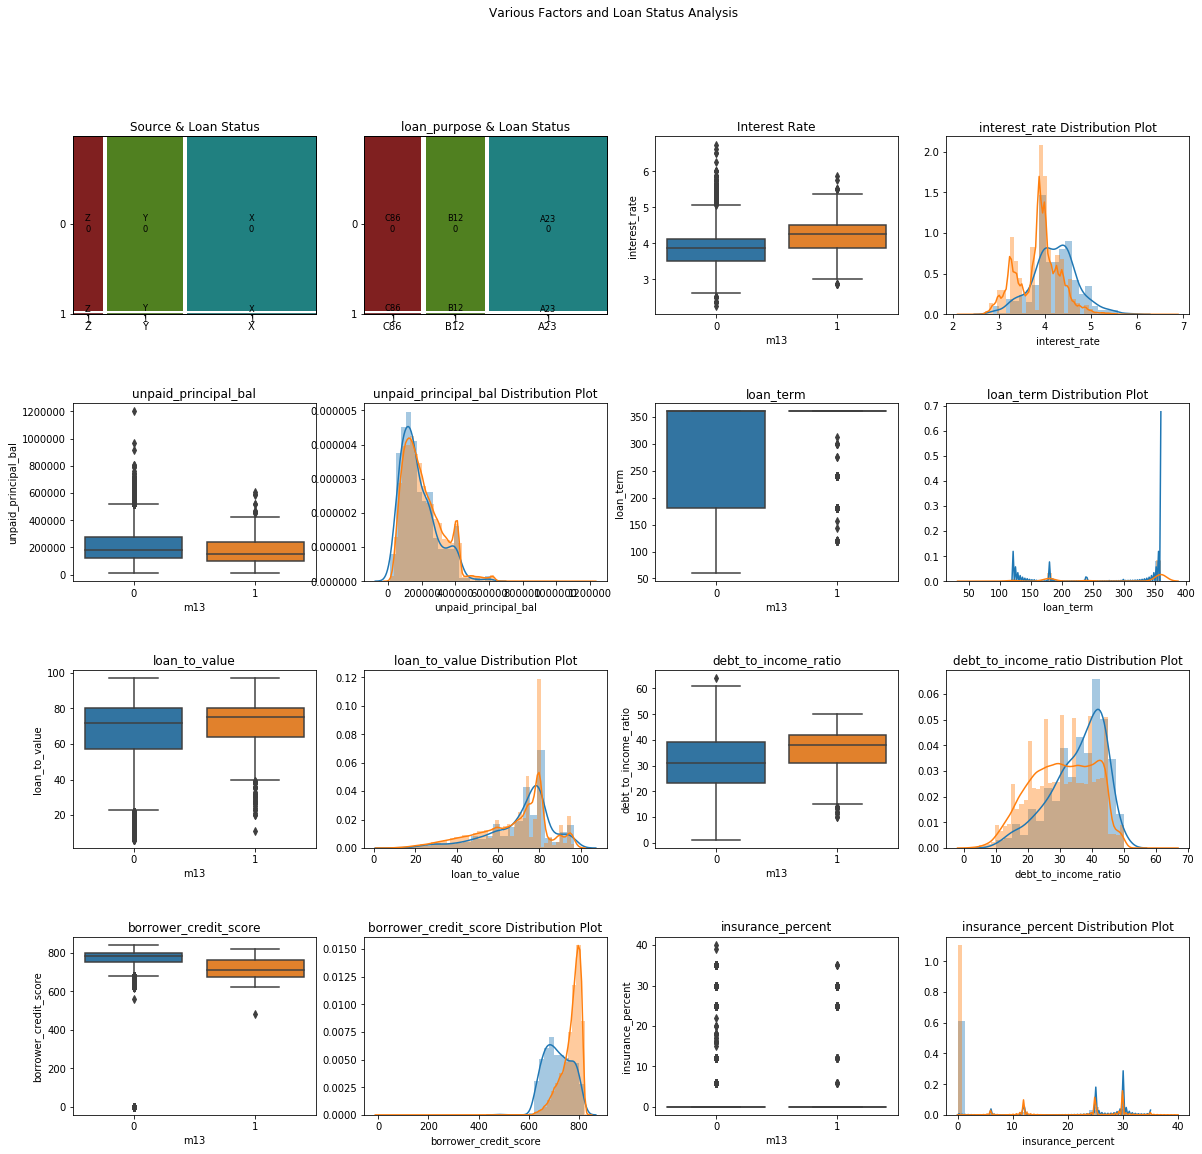

In [15]:
from statsmodels.graphics.mosaicplot import mosaic

f, axes = plt.subplots(4, 4, figsize=(20, 18))
f.subplots_adjust(hspace=0.5)
f.suptitle('Various Factors and Loan Status Analysis');

mosaic(loan_df, ['source', 'm13'], ax = axes[0,0], gap=0.02, title ='Source & Loan Status');

mosaic(loan_df, ['loan_purpose', 'm13'], ax = axes[0,1], gap=0.02, title ='loan_purpose & Loan Status');

axes[0, 2].set(title ="Interest Rate");
sn.boxplot(data = loan_df,
            y = 'interest_rate',
            x = 'm13',
            ax = axes[0,2]);

axes[0, 3].set(title ="interest_rate Distribution Plot");
sn.distplot(loan_df[loan_df.m13 == 1]['interest_rate'],
            label="Deliquency", ax=axes[0, 3]);   # distribution of interest_rate for defuaulted loands
sn.distplot(loan_df[loan_df.m13 == 0]['interest_rate'],
            label="Non Deliquency", ax=axes[0, 3]) ;  #  distribution of interest_rate for non defuaulted loands


axes[1, 0].set(title ="unpaid_principal_bal");
sn.boxplot(data = loan_df,
            y = 'unpaid_principal_bal',
            x = 'm13',
            ax = axes[1,0]);

axes[1, 1].set(title ="unpaid_principal_bal Distribution Plot");
sn.distplot(loan_df[loan_df.m13 == 1]['unpaid_principal_bal'],
            label="Deliquency", ax=axes[1, 1]);   # distribution of unpaid_principal_bal for defuaulted loands
sn.distplot(loan_df[loan_df.m13 == 0]['unpaid_principal_bal'],
            label="Non Deliquency", ax=axes[1, 1]) ;  #  distribution of unpaid_principal_bal for non defuaulted loands


axes[1, 2].set(title ="loan_term");
sn.boxplot(data = loan_df,
            y = 'loan_term',
            x = 'm13',
            ax = axes[1,2]);

axes[1, 3].set(title ="loan_term Distribution Plot");
sn.distplot(loan_df[loan_df.m13 == 1]['loan_term'],
            label="Deliquency", ax=axes[1, 3]);   # distribution of loan_term for defuaulted loands
sn.distplot(loan_df[loan_df.m13 == 0]['loan_term'],
            label="Non Deliquency", ax=axes[1, 3]) ;  #  distribution of loan_term for non defuaulted loands



axes[2, 0].set(title ="loan_to_value");
sn.boxplot(data = loan_df,
            y = 'loan_to_value',
            x = 'm13',
            ax = axes[2,0]);

axes[2, 1].set(title ="loan_to_value Distribution Plot");
sn.distplot(loan_df[loan_df.m13 == 1]['loan_to_value'],
            label="Deliquency", ax=axes[2, 1]);   # distribution of loan_to_value for defuaulted loands
sn.distplot(loan_df[loan_df.m13 == 0]['loan_to_value'],
            label="Non Deliquency", ax=axes[2, 1]) ;  #  distribution of loan_to_value for non defuaulted loands


axes[2, 2].set(title ="debt_to_income_ratio");
sn.boxplot(data = loan_df,
            y = 'debt_to_income_ratio',
            x = 'm13',
            ax = axes[2,2]);

axes[2, 3].set(title ="debt_to_income_ratio Distribution Plot");
sn.distplot(loan_df[loan_df.m13 == 1]['debt_to_income_ratio'],
            label="Deliquency", ax=axes[2, 3]);   # distribution of debt_to_income_ratio for defuaulted loands
sn.distplot(loan_df[loan_df.m13 == 0]['debt_to_income_ratio'],
            label="Non Deliquency", ax=axes[2, 3]) ;  #  distribution of debt_to_income_ratio for non defuaulted loands


axes[3, 0].set(title ="borrower_credit_score");
sn.boxplot(data = loan_df,
            y = 'borrower_credit_score',
            x = 'm13',
            ax = axes[3,0]);

axes[3, 1].set(title ="borrower_credit_score Distribution Plot");
sn.distplot(loan_df[loan_df.m13 == 1]['borrower_credit_score'],
            label="Deliquency", ax=axes[3, 1]);   # distribution of borrower_credit_score for defuaulted loands
sn.distplot(loan_df[loan_df.m13 == 0]['borrower_credit_score'],
            label="Non Deliquency", ax=axes[3, 1]) ;  #  distribution of borrower_credit_score for non defuaulted loands

axes[3, 2].set(title ="insurance_percent");
sn.boxplot(data = loan_df,
            y = 'insurance_percent',
            x = 'm13',
            ax = axes[3,2]);

axes[3, 3].set(title ="insurance_percent Distribution Plot");
sn.distplot(loan_df[loan_df.m13 == 1]['insurance_percent'],
            label="Deliquency", ax=axes[3, 3]);   # distribution of insurance_percent for defuaulted loands
sn.distplot(loan_df[loan_df.m13 == 0]['insurance_percent'],
            label="Non Deliquency", ax=axes[3, 3]) ;  #  distribution of insurance_percent for non defuaulted loands


## Feature Engineering -1

In [16]:
loan_df["Days_to_Fist_Payment"] = pd.to_numeric( (loan_df["first_payment_date"]
                                                  - loan_df["origination_date"]) / 60/60/24/1000000000)

loan_df["no_of_deliquents"] = (loan_df.m1 + loan_df.m2 + loan_df.m3 + loan_df.m4 + loan_df.m5 + loan_df.m6 + loan_df.m7 +
                             loan_df.m8 + loan_df.m9 + loan_df.m10 + loan_df.m11 + loan_df.m12);

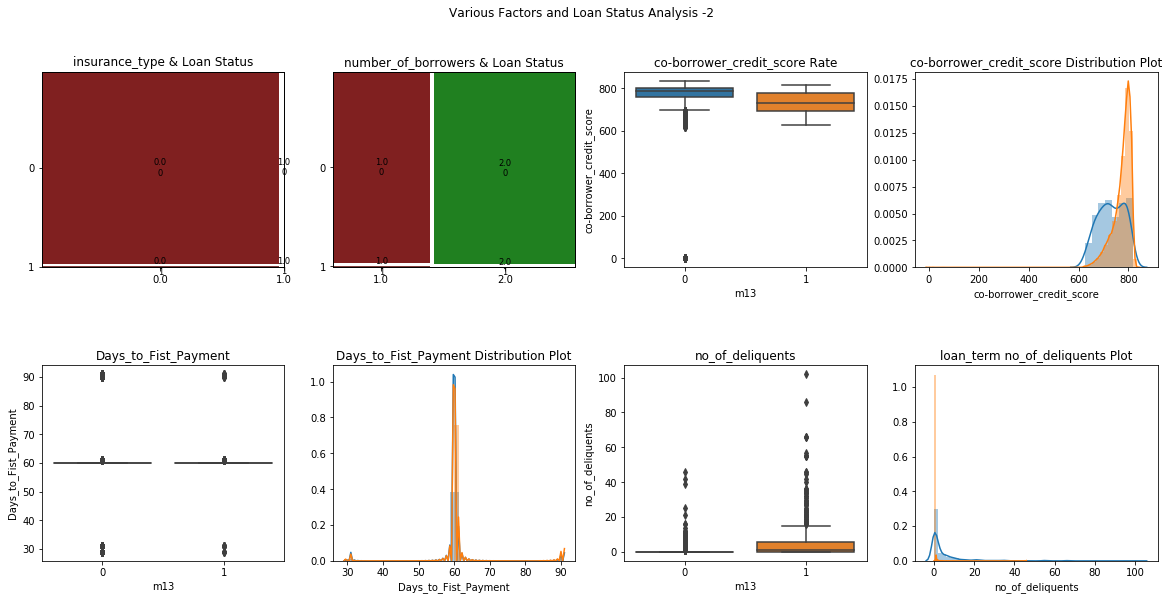

In [17]:
from statsmodels.graphics.mosaicplot import mosaic

f, axes = plt.subplots(2, 4, figsize=(20, 9))
f.subplots_adjust(hspace=0.5)
f.suptitle('Various Factors and Loan Status Analysis -2');

mosaic(loan_df, ['insurance_type', 'm13'], ax = axes[0,0], gap=0.02, title ='insurance_type & Loan Status');

mosaic(loan_df, ['number_of_borrowers', 'm13'], ax = axes[0,1], gap=0.02, title ='number_of_borrowers & Loan Status');


axes[0, 2].set(title ="co-borrower_credit_score Rate");
sn.boxplot(data = loan_df[loan_df.number_of_borrowers == 2],
            y = 'co-borrower_credit_score',
            x = 'm13',
            ax = axes[0,2]);

axes[0, 3].set(title ="co-borrower_credit_score Distribution Plot");
sn.distplot(loan_df[ (loan_df.m13 == 1) & (loan_df.number_of_borrowers == 2)]['co-borrower_credit_score'],
            label="Deliquency", ax=axes[0, 3]);   # distribution of co-borrower_credit_score for defuaulted loands
sn.distplot(loan_df[(loan_df.m13 == 0) & (loan_df.number_of_borrowers == 2)]['co-borrower_credit_score'],
            label="Non Deliquency", ax=axes[0, 3]) ;  #  distribution of co-borrower_credit_score for non defuaulted loands



axes[1, 0].set(title ="Days_to_Fist_Payment");
sn.boxplot(data = loan_df,
            y = 'Days_to_Fist_Payment',
            x = 'm13',
            ax = axes[1,0]);

axes[1, 1].set(title ="Days_to_Fist_Payment Distribution Plot");
sn.distplot(loan_df[ (loan_df.m13 == 1) ]['Days_to_Fist_Payment'],
            label="Deliquency", ax=axes[1, 1]);   # distribution of Days_to_Fist_Payment for defuaulted loands
sn.distplot(loan_df[(loan_df.m13 == 0)]['Days_to_Fist_Payment'],
            label="Non Deliquency", ax=axes[1, 1]) ;  #  distribution of Days_to_Fist_Payment for non defuaulted loands


axes[1, 2].set(title ="no_of_deliquents");
sn.boxplot(data = loan_df,
            y = 'no_of_deliquents',
            x = 'm13',
            ax = axes[1,2]);

axes[1, 3].set(title ="loan_term no_of_deliquents Plot");
sn.distplot(loan_df[loan_df.m13 == 1]['no_of_deliquents'],
            label="Deliquency", ax=axes[1, 3]);   # distribution of no_of_deliquents for defuaulted loands
sn.distplot(loan_df[loan_df.m13 == 0]['no_of_deliquents'],
            label="Non Deliquency", ax=axes[1, 3]) ;  #  distribution of no_of_deliquents for non defuaulted loands


## Observations from Exploratory data analysis and Summary statistics

- When insurance_type is 1(premium paid by Lendor), chances of deliquent seems to increase compared to when the premium is paid by the barrower.
- when the **Interest rate** is more, chances of deliquent increases.
- Following attributes seems to influence the deliquence of a loan.
    - unpaid_principal_bal
    - loan_to_value
    - debt_to_income_ratio
    - borrower_credit_score
    - co-borrower_credit_score 
    - no_of_deliquents (in the previous months)
    
Next, we perform the following to understand different variables.

- 1. Zero variance or near zero variance of different attributes
- 2. Corelation among independent attributes
- 3. one variable logistic regression to understand how a given attribute influences Deliquent
- 4. Complete logistic regression considering the significant variables from step 3 above.


## Feature selection

In [18]:
X_features = list(loan_df.columns)

In [19]:
X_features.remove('loan_id')
X_features.remove('m13')
X_features.remove('origination_date')
X_features.remove('first_payment_date');

In [20]:
encoded_loan_df = pd.get_dummies(loan_df[X_features], drop_first=True);
loan_df["Delquent_status"] = loan_df.m13>0;

Y = pd.get_dummies(loan_df[['Delquent_status']],
                            drop_first = True); 

In [21]:
encoded_loan_df.columns

Index(['interest_rate', 'unpaid_principal_bal', 'loan_term', 'loan_to_value',
       'number_of_borrowers', 'debt_to_income_ratio', 'borrower_credit_score',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'Days_to_Fist_Payment', 'no_of_deliquents', 'source_Y', 'source_Z',
       'financial_institution_Browning-Hart',
       'financial_institution_Chapman-Mcmahon',
       'financial_institution_Cole, Brooks and Vincent',
       'financial_institution_Edwards-Hoffman',
       'financial_institution_Martinez, Duffy and Bird',
       'financial_institution_Miller, Mcclure and Allen',
       'financial_institution_Nicholson Group', 'financial_institution_OTHER',
       'financial_institution_Richards-Walters',
       'financial_institution_Richardson Ltd',
       'financial_institution_Romero, Woods and Johnson',
       'financial_institution_Sanchez, Hays and Wilkerson',
     

We create the following function, which does the one-variable logistic regression. We use this iteratively, to identify the relevant variables.

In [22]:
def one_var_reg(X_train, Y_train):
    cols = [];
    for  col in X_train.columns:
        x_0 = sm.add_constant(X_train[col]);
        logit_0 = sm.Logit(Y_train, x_0);
        logit_model_0 = logit_0.fit();
        
        # if (logit_model_1.pvalues[1] <= 0.1):
        cols.append([col,np.round(logit_model_0.pvalues[1],4)]);
    
    return  pd.DataFrame(cols,columns =["Variable", "p-val in one variable regression"])

In [23]:
one_var_reg_significance = one_var_reg(encoded_loan_df,Y);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.032562
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033839
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033693
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033855
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033213
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033233
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032467
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033982
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033101
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.033967
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033996
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033997
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033997
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033997
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033992
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033992
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033992
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033989
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.03396

In [24]:
one_var_reg_significance

,Variable,p-val in one variable regression
0,interest_rate,0.0000
1,unpaid_principal_bal,0.0000
2,loan_term,0.0000
3,loan_to_value,0.0000
4,number_of_borrowers,0.0000
5,debt_to_income_ratio,0.0000
6,borrower_credit_score,0.0000
7,insurance_percent,0.0518
8,co-borrower_credit_score,0.0000
9,insurance_type,0.0480


From the above results, we consider the variables, with p-value less than 0.05

In [25]:
sig_vars = one_var_reg_significance[one_var_reg_significance["p-val in one variable regression"]<0.05];

In [26]:
sig_vars

,Variable,p-val in one variable regression
0,interest_rate,0.0000
1,unpaid_principal_bal,0.0000
2,loan_term,0.0000
3,loan_to_value,0.0000
4,number_of_borrowers,0.0000
5,debt_to_income_ratio,0.0000
6,borrower_credit_score,0.0000
8,co-borrower_credit_score,0.0000
9,insurance_type,0.0480
10,m1,0.0000


We build the corelation matrix of the above considered variables.

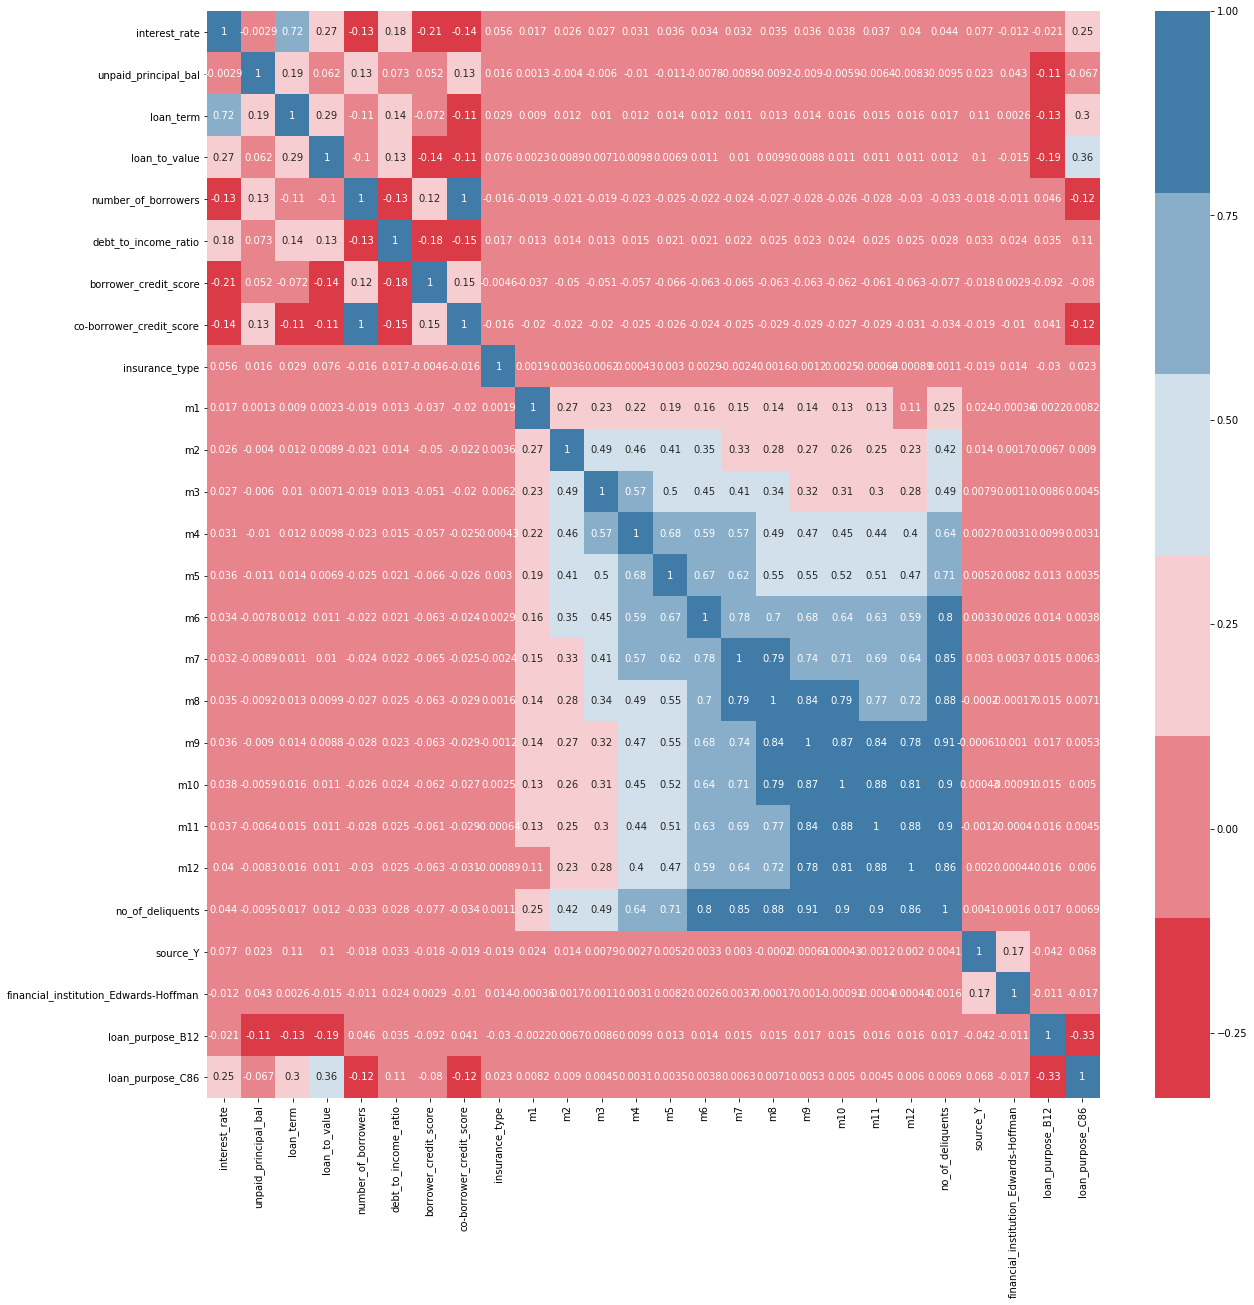

In [27]:
corr_mat = encoded_loan_df[sig_vars.Variable].corr();

plt.figure(figsize=(20,20))

sn.heatmap(corr_mat,
           annot = True,
          cmap = sn.diverging_palette(10,240));

We see that 'No_of delequents' is highly corelated with m1, m2, m3, m4... m12. Hence we retain No. of delequents and remove the other variables.

In [28]:
sig_vars = sig_vars.drop([10,11,12,13,14,15,16,17,18,19,20,21], axis=0)

In [29]:
sig_vars

,Variable,p-val in one variable regression
0,interest_rate,0.0000
1,unpaid_principal_bal,0.0000
2,loan_term,0.0000
3,loan_to_value,0.0000
4,number_of_borrowers,0.0000
5,debt_to_income_ratio,0.0000
6,borrower_credit_score,0.0000
8,co-borrower_credit_score,0.0000
9,insurance_type,0.0480
23,no_of_deliquents,0.0000


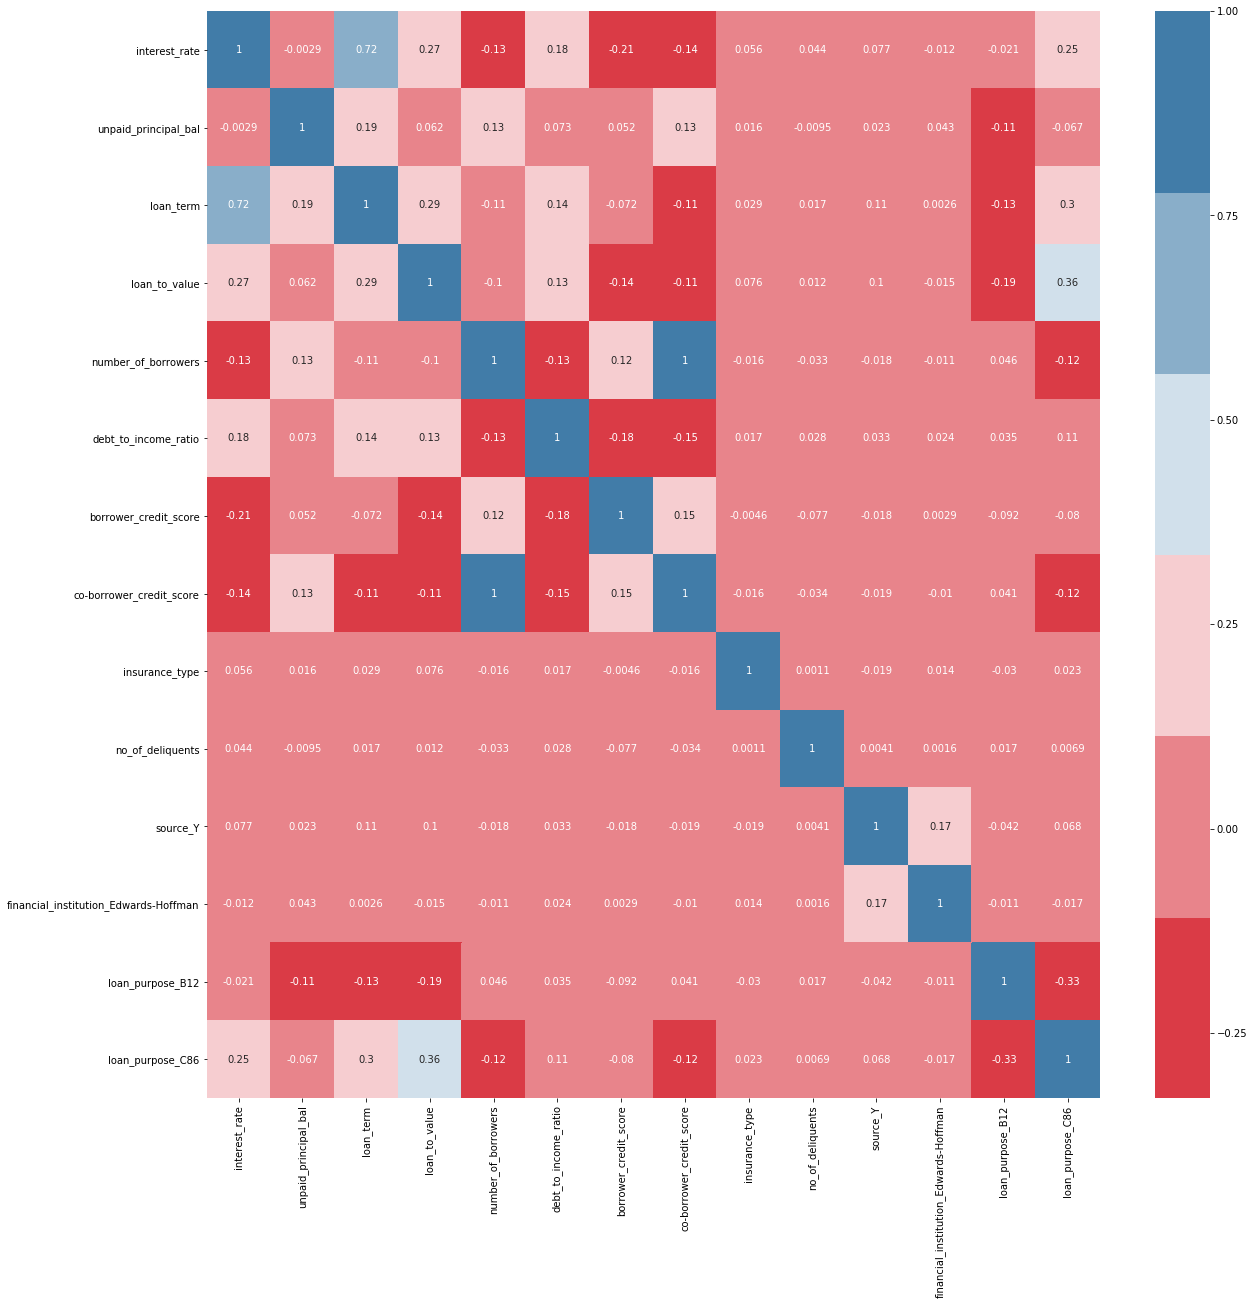

In [30]:
corr_mat = encoded_loan_df[sig_vars.Variable].corr();

plt.figure(figsize=(20,20))

sn.heatmap(corr_mat,
           annot = True,
          cmap = sn.diverging_palette(10,240));

In [31]:
X1 = sm.add_constant(encoded_loan_df[sig_vars.Variable])

In [32]:
X1 = sm.add_constant(encoded_loan_df[sig_vars.Variable])

logit1 = sm.Logit(Y,X1);

logit1_model = logit1.fit();

Optimization terminated successfully.
         Current function value: 0.023116
         Iterations 10


In [33]:
Y.columns

Index(['Delquent_status'], dtype='object')

In [34]:
logit1_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Logit
======================================================================================
Model:                      Logit                   Pseudo R-squared:        0.320    
Dependent Variable:         Delquent_status         AIC:                     5395.6280
Date:                       2019-08-24 19:29        BIC:                     5540.5557
No. Observations:           116058                  Log-Likelihood:          -2682.8  
Df Model:                   14                      LL-Null:                 -3945.7  
Df Residuals:               116043                  LLR p-value:             0.0000   
Converged:                  1.0000                  Scale:                   1.0000   
No. Iterations:             10.0000                                                   
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------
const                                 -6.3096   0.9930  -6.3539 0.0000 -8.2559 -4.3633
interest_rate                          0.7315   0.1262   5.7949 0.0000  0.4841  0.9789
unpaid_principal_bal                  -0.0000   0.0000  -1.9389 0.0525 -0.0000  0.0000
loan_term                             -0.0006   0.0008  -0.7768 0.4373 -0.0022  0.0010
loan_to_value                          0.0032   0.0034   0.9379 0.3483 -0.0034  0.0098
number_of_borrowers                    0.9957   0.6512   1.5291 0.1262 -0.2806  2.2720
debt_to_income_ratio                   0.0352   0.0055   6.3797 0.0000  0.0244  0.0460
borrower_credit_score                 -0.0054   0.0005 -10.6219 0.0000 -0.0065 -0.0044
co-borrower_credit_score              -0.0021   0.0009  -2.4423 0.0146 -0.0038 -0.0004
insurance_type                         0.6481   0.5156   1.2571 0.2087 -0.3624  1.6587
no_of_deliquents                       0.8473   0.0306  27.7322 0.0000  0.7874  0.9072
source_Y                               0.1667   0.1000   1.6677 0.0954 -0.0292  0.3627
financial_institution_Edwards-Hoffman  0.3311   0.1990   1.6634 0.0962 -0.0590  0.7212
loan_purpose_B12                       0.1992   0.1195   1.6671 0.0955 -0.0350  0.4333
loan_purpose_C86                       0.0298   0.1252   0.2382 0.8117 -0.2155  0.2751
======================================================================================

"""

as Interest and Loan term are corelated with .7 and loan_term p-value is .4373. we remove the Loan term and rebuild the model.

In [35]:
sig_vars = sig_vars.drop([2], axis=0)

In [36]:
X2 = sm.add_constant(encoded_loan_df[sig_vars.Variable])

logit2 = sm.Logit(Y,X2);

logit2_model = logit2.fit();

Optimization terminated successfully.
         Current function value: 0.023119
         Iterations 10


In [37]:
logit2_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Logit
======================================================================================
Model:                      Logit                   Pseudo R-squared:        0.320    
Dependent Variable:         Delquent_status         AIC:                     5394.2268
Date:                       2019-08-24 19:29        BIC:                     5529.4926
No. Observations:           116058                  Log-Likelihood:          -2683.1  
Df Model:                   13                      LL-Null:                 -3945.7  
Df Residuals:               116044                  LLR p-value:             0.0000   
Converged:                  1.0000                  Scale:                   1.0000   
No. Iterations:             10.0000                                                   
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------
const                                 -6.2401   0.9895  -6.3064 0.0000 -8.1794 -4.3007
interest_rate                          0.6749   0.1039   6.4936 0.0000  0.4712  0.8785
unpaid_principal_bal                  -0.0000   0.0000  -2.2384 0.0252 -0.0000 -0.0000
loan_to_value                          0.0031   0.0034   0.9091 0.3633 -0.0035  0.0096
number_of_borrowers                    1.0069   0.6510   1.5468 0.1219 -0.2690  2.2828
debt_to_income_ratio                   0.0352   0.0055   6.3847 0.0000  0.0244  0.0461
borrower_credit_score                 -0.0055   0.0005 -10.7191 0.0000 -0.0065 -0.0045
co-borrower_credit_score              -0.0021   0.0009  -2.4530 0.0142 -0.0038 -0.0004
insurance_type                         0.6568   0.5156   1.2738 0.2027 -0.3538  1.6673
no_of_deliquents                       0.8472   0.0306  27.7304 0.0000  0.7873  0.9071
source_Y                               0.1636   0.0999   1.6386 0.1013 -0.0321  0.3594
financial_institution_Edwards-Hoffman  0.3361   0.1989   1.6904 0.0910 -0.0536  0.7259
loan_purpose_B12                       0.2055   0.1192   1.7239 0.0847 -0.0281  0.4391
loan_purpose_C86                       0.0154   0.1236   0.1242 0.9012 -0.2270  0.2577
======================================================================================

"""

From the above summary, we remove the attributes which are not significant.

In [38]:
sig_vars = sig_vars.drop([3,4,9,24,29,44,45], axis=0)

In [39]:
sig_vars

,Variable,p-val in one variable regression
0,interest_rate,0.0
1,unpaid_principal_bal,0.0
5,debt_to_income_ratio,0.0
6,borrower_credit_score,0.0
8,co-borrower_credit_score,0.0
23,no_of_deliquents,0.0


In [40]:
X3 = sm.add_constant(encoded_loan_df[sig_vars.Variable])

logit3 = sm.Logit(Y,X3);

logit3_model = logit3.fit();

Optimization terminated successfully.
         Current function value: 0.023178
         Iterations 10


In [46]:
logit3_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                 Logit               Pseudo R-squared:    0.318    
Dependent Variable:    Delquent_status     AIC:                 5394.0159
Date:                  2019-08-20 19:27    BIC:                 5461.6488
No. Observations:      116058              Log-Likelihood:      -2690.0  
Df Model:              6                   LL-Null:             -3945.7  
Df Residuals:          116051              LLR p-value:         0.0000   
Converged:             1.0000              Scale:               1.0000   
No. Iterations:        10.0000                                           
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
const                    -4.9753   0.5767  -8.6268 0.0000 -6.1057 -3.8450
interest_rate             0.7310   0.0997   7.3356 0.0000  0.5357  0.9264
unpaid_principal_bal     -0.0000   0.0000  -2.2755 0.0229 -0.0000 -0.0000
debt_to_income_ratio      0.0365   0.0055   6.6800 0.0000  0.0258  0.0472
borrower_credit_score    -0.0057   0.0004 -12.7765 0.0000 -0.0066 -0.0048
co-borrower_credit_score -0.0008   0.0001  -6.0781 0.0000 -0.0011 -0.0005
no_of_deliquents          0.8557   0.0305  28.0404 0.0000  0.7959  0.9155
=========================================================================

"""

In [60]:
preicted_prob1 = logit3_model.predict(X3);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob1": preicted_prob1})

y_pred_df['predicted1'] = y_pred_df.predicted_prob1.map(lambda x: 1 if x > 0.5 else 0)

In [42]:
y_pred_df.head()

,actual,predicted_prob1,predicted1
0,True,0.012328,0
1,True,0.044398,0
2,True,0.001997,0
3,True,0.324309,0
4,True,1.000000,1


We create the below funciton to draw the confusion matrix.

In [58]:
from sklearn import metrics
def draw_cm(actual, predicted):
    cm = metrics.confusion_matrix(actual, predicted,[1,0])
    sn.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Deliquency', 'Non Deliquency'],
               yticklabels = ['Deliquency', 'Non Deliquency'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

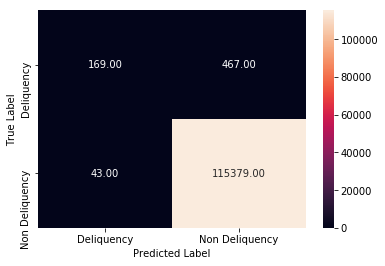

In [61]:
draw_cm(y_pred_df.actual, y_pred_df.predicted1)

In [45]:
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted1))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.80      0.27      0.40       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.90      0.63      0.70    116058
weighted avg       0.99      1.00      0.99    116058



We create the below function to draw the **ROC** curve

In [46]:
def draw_roc(actual, probs):
    fpr,tpr,thresholds = metrics.roc_curve(actual,probs,drop_intermediate = False)
    
    auc_score = metrics.roc_auc_score(actual,probs)
    plt.figure(figsize=(8,6))

    plt.plot(fpr,tpr,label='ROC curve( area = %0.2f)' %auc_score)

    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

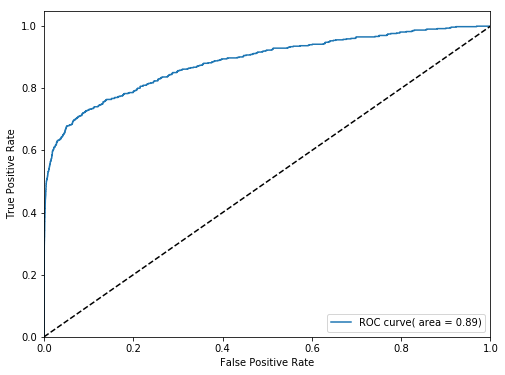

In [47]:
fpr, tpr, thresholds = draw_roc(y_pred_df.actual, y_pred_df.predicted_prob1)

Young's index calculations

In [56]:
tpr_fpr = pd.DataFrame({'tpr' : tpr, 'fpr' : fpr, 'thresholds' : thresholds })
tpr_fpr['diff'] = tpr_fpr.tpr - tpr_fpr.fpr
tpr_fpr.sort_values('diff', ascending = False)[0:5]

,tpr,fpr,thresholds,diff
11285,0.727987,0.093951,0.007189,0.634037
11286,0.727987,0.093960,0.007189,0.634028
11287,0.727987,0.093968,0.007189,0.634019
11288,0.727987,0.093977,0.007189,0.634011
11289,0.727987,0.093986,0.007188,0.634002


We identify the threshhold, (from trial and error), which maximizes the f1-score

In [48]:
y_pred_df['predicted_new1'] = y_pred_df.predicted_prob1.map(lambda x: 1 if x > 0.085 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_new1))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.57      0.36      0.45       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.78      0.68      0.72    116058
weighted avg       0.99      1.00      0.99    116058



Following are the variables which are considered for now. We also see that F1-score is .45 on the training data. We do the feature engineering to improve this.

In [50]:
sig_vars

,Variable,p-val in one variable regression
0,interest_rate,0.0
1,unpaid_principal_bal,0.0
5,debt_to_income_ratio,0.0
6,borrower_credit_score,0.0
8,co-borrower_credit_score,0.0
23,no_of_deliquents,0.0


We think, rather than no_of_deliquents, whether a person has committed deliquency or not is important. Also, whether his deliquency pattern is increasing or decreasing

In [60]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116058 entries, 0 to 116057
Data columns (total 32 columns):
loan_id                     116058 non-null int64
source                      116058 non-null object
financial_institution       116058 non-null object
interest_rate               116058 non-null float64
unpaid_principal_bal        116058 non-null int64
loan_term                   116058 non-null int64
origination_date            116058 non-null datetime64[ns]
first_payment_date          116058 non-null datetime64[ns]
loan_to_value               116058 non-null int64
number_of_borrowers         116058 non-null float64
debt_to_income_ratio        116058 non-null float64
borrower_credit_score       116058 non-null float64
loan_purpose                116058 non-null object
insurance_percent           116058 non-null float64
co-borrower_credit_score    116058 non-null float64
insurance_type              116058 non-null float64
m1                          116058 non-null int64
m2  

## Feature Engineering -2 

In [54]:
loan_df["isDelequent"] = loan_df.no_of_deliquents.map(lambda x: 1 if x>0 else 0);

In [55]:
loan_df["deliquency_score"] = (loan_df.m2- loan_df.m1 + 
                              loan_df.m3- loan_df.m2 + 
                              loan_df.m4- loan_df.m3 + 
                              loan_df.m5- loan_df.m4 + 
                              loan_df.m6- loan_df.m5 + 
                              loan_df.m7- loan_df.m6 + 
                              loan_df.m8- loan_df.m7 + 
                              loan_df.m9- loan_df.m8 + 
                              loan_df.m10- loan_df.m9 + 
                              loan_df.m11- loan_df.m10 + 
                              loan_df.m12- loan_df.m11  );

loan_df["new_cred_score"] =  ((1/loan_df.number_of_borrowers)*loan_df.borrower_credit_score +
                              (loan_df.number_of_borrowers-1)/loan_df.number_of_borrowers*
                              loan_df["co-borrower_credit_score"])

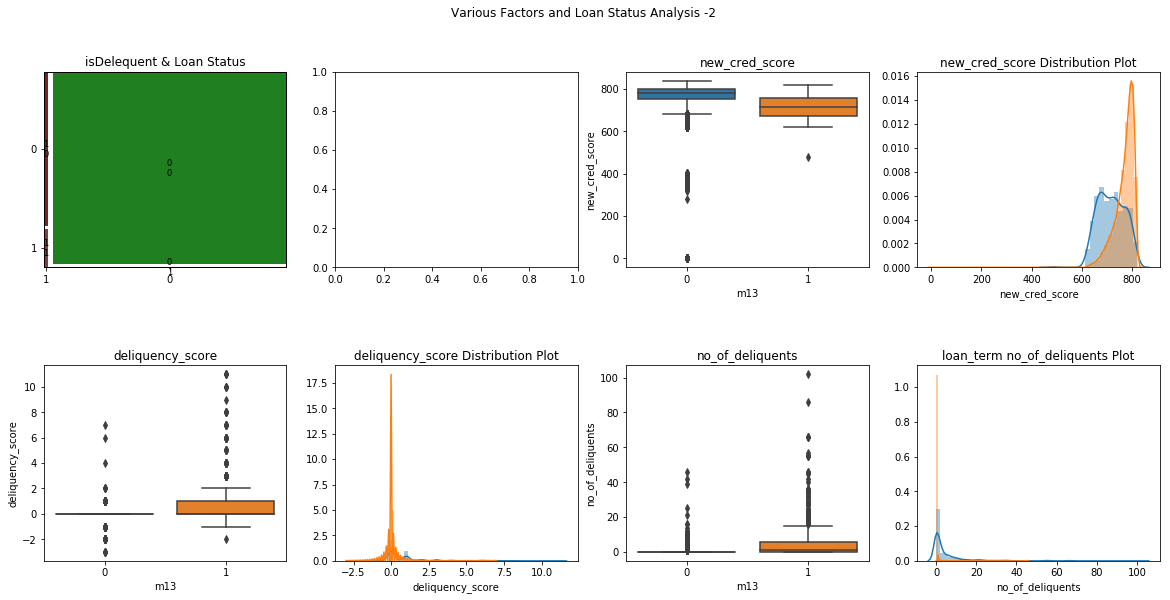

In [62]:
from statsmodels.graphics.mosaicplot import mosaic

f, axes = plt.subplots(2, 4, figsize=(20, 9))
f.subplots_adjust(hspace=0.5)
f.suptitle('Various Factors and Loan Status Analysis -2');

mosaic(loan_df, ['isDelequent', 'm13'], ax = axes[0,0], gap=0.02, title ='isDelequent & Loan Status');


axes[0, 2].set(title ="new_cred_score");
sn.boxplot(data = loan_df,
            y = 'new_cred_score',
            x = 'm13',
            ax = axes[0,2]);

axes[0, 3].set(title ="new_cred_score Distribution Plot");
sn.distplot(loan_df[ (loan_df.m13 == 1)]['new_cred_score'],
            label="Deliquency", ax=axes[0, 3]);   # distribution of co-borrower_credit_score for defuaulted loands
sn.distplot(loan_df[(loan_df.m13 == 0) ]['new_cred_score'],
            label="Non Deliquency", ax=axes[0, 3]) ;  #  distribution of co-borrower_credit_score for non defuaulted loands



axes[1, 0].set(title ="deliquency_score");
sn.boxplot(data = loan_df,
            y = 'deliquency_score',
            x = 'm13',
            ax = axes[1,0]);

axes[1, 1].set(title ="deliquency_score Distribution Plot");
sn.distplot(loan_df[ (loan_df.m13 == 1) ]['deliquency_score'],
            label="Deliquency", ax=axes[1, 1]);   # distribution of Days_to_Fist_Payment for defuaulted loands
sn.distplot(loan_df[(loan_df.m13 == 0)]['deliquency_score'],
            label="Non Deliquency", ax=axes[1, 1]) ;  #  distribution of Days_to_Fist_Payment for non defuaulted loands


axes[1, 2].set(title ="no_of_deliquents");
sn.boxplot(data = loan_df,
            y = 'no_of_deliquents',
            x = 'm13',
            ax = axes[1,2]);

axes[1, 3].set(title ="loan_term no_of_deliquents Plot");
sn.distplot(loan_df[loan_df.m13 == 1]['no_of_deliquents'],
            label="Deliquency", ax=axes[1, 3]);   # distribution of no_of_deliquents for defuaulted loands
sn.distplot(loan_df[loan_df.m13 == 0]['no_of_deliquents'],
            label="Not Deliquency", ax=axes[1, 3]) ;  #  distribution of no_of_deliquents for non defuaulted loands


In [63]:
sig_vars.Variable

0                interest_rate
1         unpaid_principal_bal
5         debt_to_income_ratio
6        borrower_credit_score
8     co-borrower_credit_score
23            no_of_deliquents
Name: Variable, dtype: object

We consider the following list, we include "unpaid_principal_bal" (which as $\beta$ as 0) and include loan_term in the model.

In [64]:
varList =["interest_rate", "loan_term","debt_to_income_ratio", "no_of_deliquents", "new_cred_score",
          "isDelequent","deliquency_score" ]

In [65]:
loan_df[varList].head()

,interest_rate,loan_term,debt_to_income_ratio,no_of_deliquents,new_cred_score,isDelequent,deliquency_score
0,4.250,360,22.0,1,694.0,1,0
1,4.875,360,44.0,1,697.0,1,0
2,3.250,180,33.0,0,780.0,0,0
3,4.750,360,44.0,4,635.5,1,1
4,4.750,360,43.0,66,681.0,1,11


In [68]:
varList

['interest_rate',
 'loan_term',
 'debt_to_income_ratio',
 'no_of_deliquents',
 'new_cred_score',
 'isDelequent',
 'deliquency_score']

In [66]:
one_var_reg_significance2 = one_var_reg(loan_df[varList],Y);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.032562
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033693
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033233
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024651
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032369
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023120
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024283
         Iterations 10


In [70]:
one_var_reg_significance2

,Variable,p-val in one variable regression
0,interest_rate,0.0
1,loan_term,0.0
2,debt_to_income_ratio,0.0
3,no_of_deliquents,0.0
4,new_cred_score,0.0
5,isDelequent,0.0
6,deliquency_score,0.0


we see that, all this are individually significant

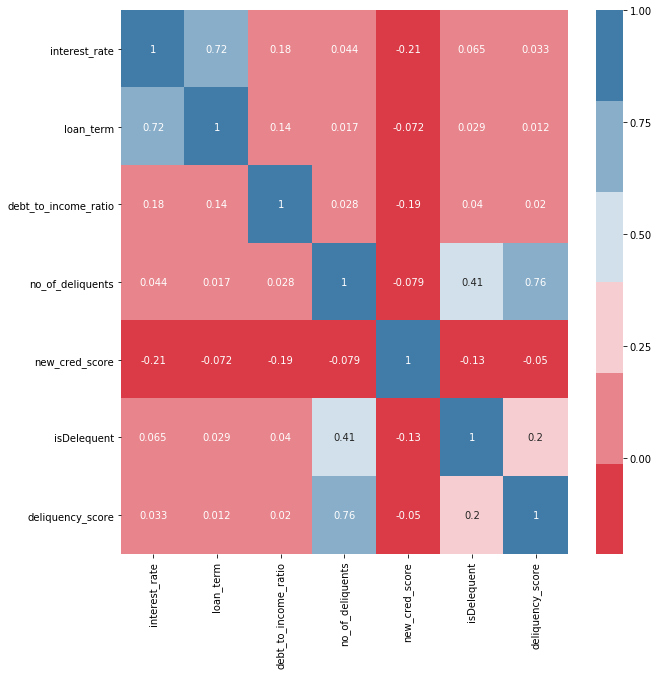

In [67]:
corr_mat = loan_df[varList].corr();

plt.figure(figsize=(10,10))

sn.heatmap(corr_mat,
           annot = True,
          cmap = sn.diverging_palette(10,240));

<font color = red> **We see that, isDelequent, deliquency_score and no_of_delequencies are corelated. Hence,we retain only deliquence_score and build the model**</font>

In [71]:
varList =["interest_rate", "unpaid_principal_bal","debt_to_income_ratio", "new_cred_score","deliquency_score","loan_term" ]

In [73]:
X4 = sm.add_constant(loan_df[varList])

logit4 = sm.Logit(Y,X4);

logit4_model = logit4.fit();

logit4_model.summary2()

Optimization terminated successfully.
         Current function value: 0.022707
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                 Logit             Pseudo R-squared:  0.332    
Dependent Variable:    Delquent_status   AIC:               5284.5932
Date:                  2019-08-24 19:36  BIC:               5352.2261
No. Observations:      116058            Log-Likelihood:    -2635.3  
Df Model:              6                 LL-Null:           -3945.7  
Df Residuals:          116051            LLR p-value:       0.0000   
Converged:             1.0000            Scale:             1.0000   
No. Iterations:        10.0000                                       
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -4.6777   0.5786  -8.0848 0.0000 -5.8117 -3.5437
interest_rate         0.8433   0.1242   6.7908 0.0000  0.5999  1.0867
unpaid_principal_bal -0.0000   0.0000  -3.2470 0.0012 -0.0000 -0.0000
debt_to_income_ratio  0.0416   0.0054   7.6682 0.0000  0.0309  0.0522
new_cred_score       -0.0071   0.0004 -15.7535 0.0000 -0.0079 -0.0062
deliquency_score      4.5019   0.1268  35.5162 0.0000  4.2535  4.7504
loan_term            -0.0004   0.0008  -0.5271 0.5981 -0.0019  0.0011
=====================================================================

"""

From the above results, we see that **Loan term** is coming as not significant. Also, Loan_tern and interest rate are highly corelated. 

In [74]:
varList =["interest_rate","debt_to_income_ratio", "no_of_deliquents", "new_cred_score",
          "isDelequent","deliquency_score" ]

In [75]:
X5 = sm.add_constant(loan_df[varList])

logit5 = sm.Logit(Y,X5);

logit5_model = logit5.fit();

logit5_model.summary2()

Optimization terminated successfully.
         Current function value: 0.019435
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit             Pseudo R-squared:  0.428    
Dependent Variable:   Delquent_status   AIC:               4525.1366
Date:                 2019-08-24 19:36  BIC:               4592.7695
No. Observations:     116058            Log-Likelihood:    -2255.6  
Df Model:             6                 LL-Null:           -3945.7  
Df Residuals:         116051            LLR p-value:       0.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       10.0000                                       
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
const                -5.4180   0.6650 -8.1479 0.0000 -6.7213 -4.1147
interest_rate         0.5934   0.1040  5.7035 0.0000  0.3895  0.7973
debt_to_income_ratio  0.0330   0.0055  5.9653 0.0000  0.0222  0.0439
no_of_deliquents      0.1839   0.0277  6.6472 0.0000  0.1297  0.2381
new_cred_score       -0.0055   0.0006 -9.4300 0.0000 -0.0067 -0.0044
isDelequent           3.2626   0.1276 25.5760 0.0000  3.0126  3.5126
deliquency_score      1.6034   0.1197 13.3951 0.0000  1.3688  1.8380
====================================================================

"""

In [76]:
preicted_prob5 = logit5_model.predict(X5);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob5": preicted_prob5})

y_pred_df['predicted5'] = y_pred_df.predicted_prob5.map(lambda x: 1 if x > 0.5 else 0)

In [77]:
y_pred_df.head()

,actual,predicted_prob5,predicted5
0,True,0.072529,0
1,True,0.187300,0
2,True,0.001230,0
3,True,0.721573,1
4,True,1.000000,1


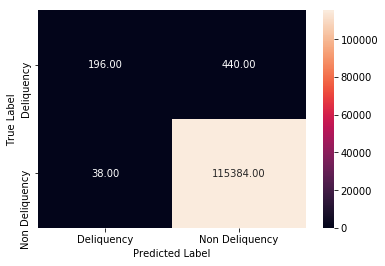

In [78]:
draw_cm(y_pred_df.actual, y_pred_df.predicted5)

In [79]:
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted5))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.84      0.31      0.45       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.92      0.65      0.72    116058
weighted avg       1.00      1.00      0.99    116058



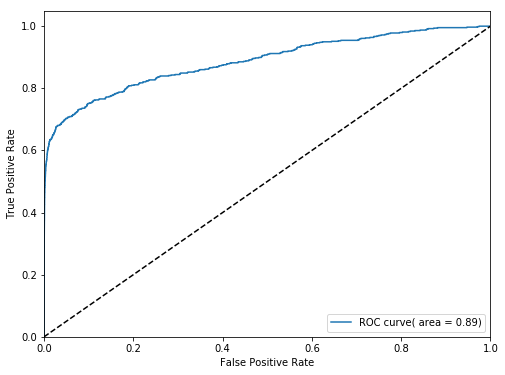

In [84]:
fpr, tpr, thresholds = draw_roc(y_pred_df.actual, y_pred_df.predicted_prob5)

In [80]:
tpr_fpr = pd.DataFrame({'tpr' : tpr, 'fpr' : fpr, 'thresholds' : thresholds })
tpr_fpr['diff'] = tpr_fpr.tpr - tpr_fpr.fpr
tpr_fpr.sort_values('diff', ascending = False)[0:5]

,tpr,fpr,thresholds,diff
11285,0.727987,0.093951,0.007189,0.634037
11286,0.727987,0.093960,0.007189,0.634028
11287,0.727987,0.093968,0.007189,0.634019
11288,0.727987,0.093977,0.007189,0.634011
11289,0.727987,0.093986,0.007188,0.634002


In [81]:
y_pred_df['predicted_new'] = y_pred_df.predicted_prob5.map(lambda x: 1 if x > 0.099 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_new))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00    115422
        True       0.37      0.56      0.45       636

   micro avg       0.99      0.99      0.99    116058
   macro avg       0.68      0.78      0.72    116058
weighted avg       0.99      0.99      0.99    116058



In the test, results - we got f1-score of 29%. We try to improve this further. We derive a deliquency score as below.
**New Deliquency Score** indicates, whethere a person is improving in his loan repayment style or not

In [82]:
loan_df["new_deliquency_score"] =    ((loan_df.m2- loan_df.m1).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m3- loan_df.m2).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m4- loan_df.m3).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m5- loan_df.m4).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m6- loan_df.m5).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m7- loan_df.m6).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m8- loan_df.m7).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m9- loan_df.m8).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m10- loan_df.m9).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m11- loan_df.m10).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                    + (loan_df.m12- loan_df.m11).map(lambda x: 1 if x>0 else (-1 if x<0 else 0)) 
                                     );

In [83]:
loan_df.sample(5)

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m11,m12,m13,Days_to_Fist_Payment,no_of_deliquents,Delquent_status,isDelequent,deliquency_score,new_cred_score,new_deliquency_score
71791,635611038176,X,Browning-Hart,4.0,210000,240,2012-01-01,2012-04-01,59,1.0,...,0,0,0,91,0,False,0,0,783.0,0
46742,446530037229,Y,OTHER,4.5,238000,360,2012-02-01,2012-04-01,95,2.0,...,0,0,0,60,0,False,0,0,687.5,0
55,194552382167,X,OTHER,4.5,70000,240,2012-02-01,2012-04-01,40,2.0,...,2,1,1,60,10,True,1,0,695.5,0
19914,333902249797,X,OTHER,4.0,136000,360,2012-02-01,2012-04-01,80,1.0,...,0,0,0,60,0,False,0,0,808.0,0
22029,232824684642,X,OTHER,4.0,81000,360,2012-02-01,2012-04-01,80,2.0,...,0,0,0,60,0,False,0,0,805.5,0


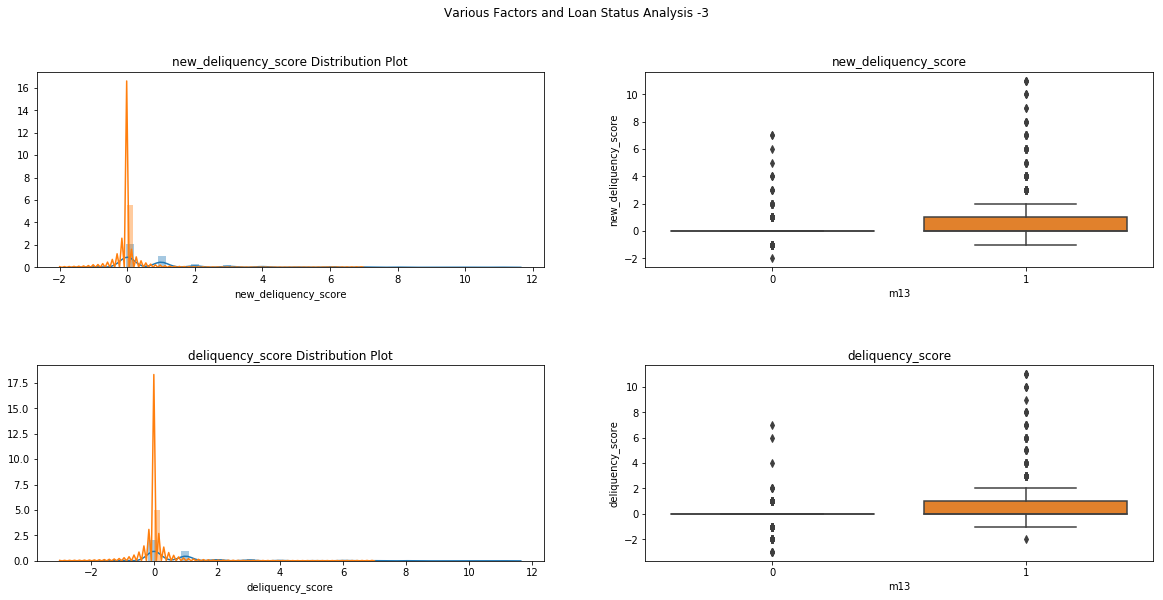

In [84]:
f, axes = plt.subplots(2, 2, figsize=(20, 9))
f.subplots_adjust(hspace=0.5)
f.suptitle('Various Factors and Loan Status Analysis -3');

axes[0,0].set(title ="new_deliquency_score Distribution Plot");
sn.distplot(loan_df[ (loan_df.m13 == 1)]['new_deliquency_score'],
            label="deliquent", ax=axes[0,0]);   # distribution of co-borrower_credit_score for defuaulted loands
sn.distplot(loan_df[(loan_df.m13 == 0) ]['new_deliquency_score'],
            label="Not Deliquent", ax=axes[0,0]) ;  #  distribution of co-borrower_credit_score for non defuaulted loands



axes[0,1].set(title ="new_deliquency_score");
sn.boxplot(data = loan_df,
            y = 'new_deliquency_score',
            x = 'm13',
            ax = axes[0,1]);


axes[1,0].set(title ="deliquency_score Distribution Plot");
sn.distplot(loan_df[ (loan_df.m13 == 1)]['deliquency_score'],
            label="deliquent", ax=axes[1,0]);   # distribution of co-borrower_credit_score for defuaulted loands
sn.distplot(loan_df[(loan_df.m13 == 0) ]['deliquency_score'],
            label="Not Deliquent", ax=axes[1,0]) ;  #  distribution of co-borrower_credit_score for non defuaulted loands



axes[1,1].set(title ="deliquency_score");
sn.boxplot(data = loan_df,
            y = 'deliquency_score',
            x = 'm13',
            ax = axes[1,1]);

In [88]:
varList =["interest_rate","debt_to_income_ratio", "new_cred_score","new_deliquency_score" ]

In [89]:
X6 = sm.add_constant(loan_df[varList])

logit6 = sm.Logit(Y,X6);

logit6_model = logit6.fit();

logit6_model.summary2()

Optimization terminated successfully.
         Current function value: 0.022923
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                 Logit             Pseudo R-squared:  0.326    
Dependent Variable:    Delquent_status   AIC:               5330.7396
Date:                  2019-08-24 19:37  BIC:               5379.0488
No. Observations:      116058            Log-Likelihood:    -2660.4  
Df Model:              4                 LL-Null:           -3945.7  
Df Residuals:          116053            LLR p-value:       0.0000   
Converged:             1.0000            Scale:             1.0000   
No. Iterations:        10.0000                                       
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -5.3340   0.5728  -9.3119 0.0000 -6.4566 -4.2113
interest_rate         0.8829   0.0992   8.8978 0.0000  0.6884  1.0774
debt_to_income_ratio  0.0392   0.0054   7.2158 0.0000  0.0285  0.0498
new_cred_score       -0.0068   0.0005 -14.8634 0.0000 -0.0077 -0.0059
new_deliquency_score  3.7520   0.1231  30.4817 0.0000  3.5107  3.9932
=====================================================================

"""

In [90]:
preicted_prob = logit6_model.predict(X6);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob": preicted_prob})

y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.5 else 0)

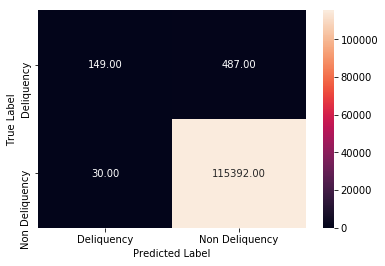

In [91]:
draw_cm(y_pred_df.actual, y_pred_df.predicted)

In [92]:
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.83      0.23      0.37       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.91      0.62      0.68    116058
weighted avg       0.99      1.00      0.99    116058



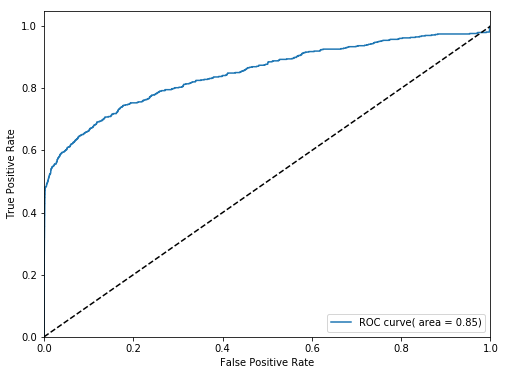

In [93]:
fpr, tpr, thresholds = draw_roc(y_pred_df.actual, y_pred_df.predicted_prob)

In [94]:
y_pred_df['predicted_new'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.085 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_new))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.54      0.47      0.50       636

   micro avg       0.99      0.99      0.99    116058
   macro avg       0.77      0.73      0.75    116058
weighted avg       0.99      0.99      0.99    116058



# <font color = green >We got 31.52% f1-score on the Testing data from the above model. </font>

# <font color = red> Below models were evaluated. But the results did not show any improvement </font>. They are documented below for reference.

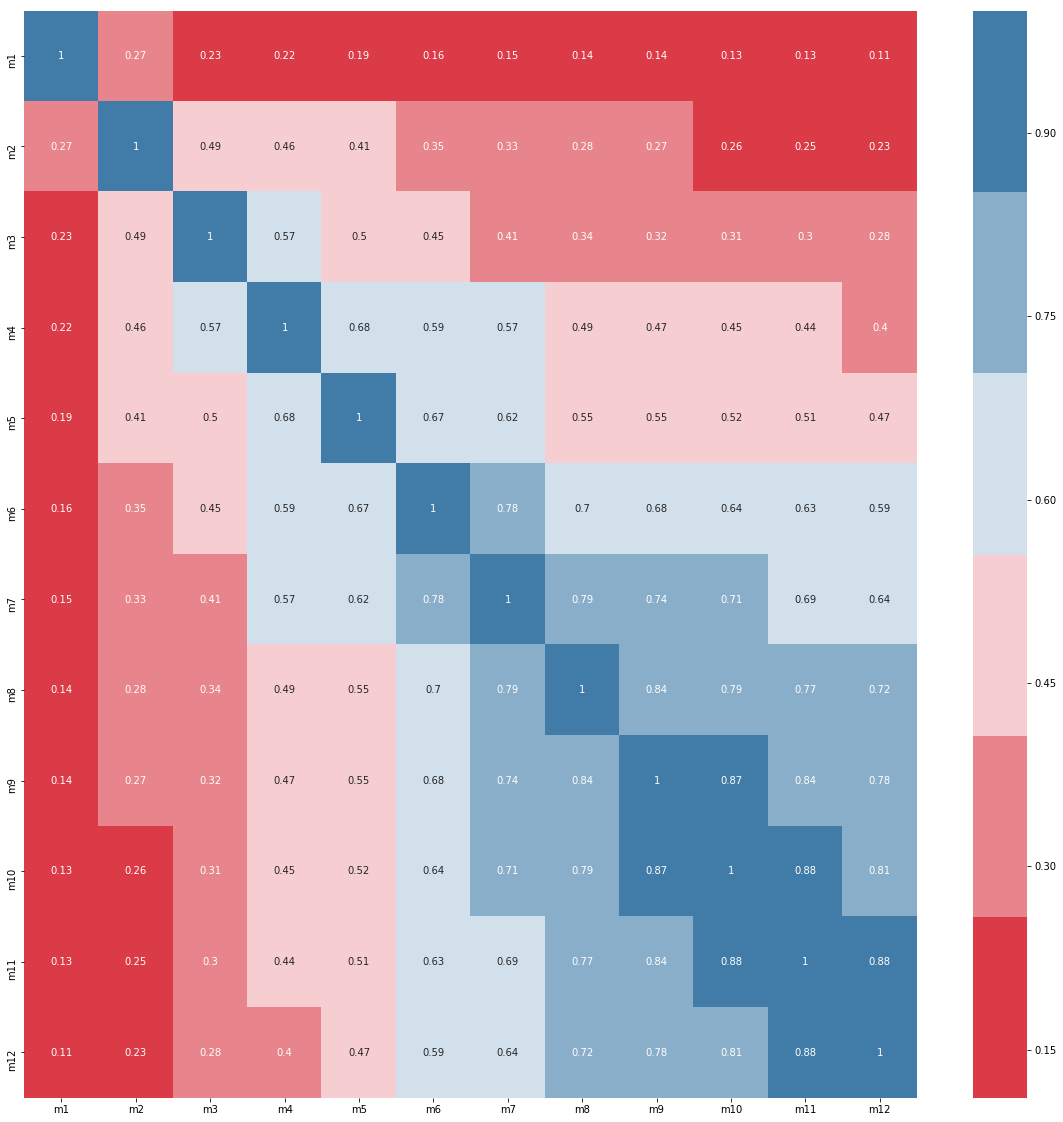

In [128]:
corr_mat = encoded_loan_df[["m1","m2","m3","m4","m5","m6","m7","m8","m9","m10",
          "m11","m12"]].corr();

plt.figure(figsize=(20,20))

sn.heatmap(corr_mat,
           annot = True,
          cmap = sn.diverging_palette(10,240));

We calculate the probability of defaulting, given barrower has deliquented in the month n.

In [129]:
del_count = loan_df.m13.map(lambda x: 1 if x>0 else 0).sum();

def fun(x):
    if x>0:
        return 1;
    else:
        return 0;
        

del_prob =[];

del_prob.append(["m1",round(loan_df[loan_df.m1 >0].m13.map(fun).sum()/loan_df.m1.map(fun).sum()*100,2)]);
del_prob.append(["m2",round(loan_df[loan_df.m2 >0].m13.map(fun).sum()/loan_df.m2.map(fun).sum()*100,2)]);
del_prob.append(["m3",round(loan_df[loan_df.m3 >0].m13.map(fun).sum()/loan_df.m3.map(fun).sum()*100,2)]);
del_prob.append(["m4",round(loan_df[loan_df.m4 >0].m13.map(fun).sum()/loan_df.m4.map(fun).sum()*100,2)]);
del_prob.append(["m5",round(loan_df[loan_df.m5 >0].m13.map(fun).sum()/loan_df.m5.map(fun).sum()*100,2)]);
del_prob.append(["m6",round(loan_df[loan_df.m6 >0].m13.map(fun).sum()/loan_df.m6.map(fun).sum()*100,2)]);
del_prob.append(["m7",round(loan_df[loan_df.m7 >0].m13.map(fun).sum()/loan_df.m7.map(fun).sum()*100,2)]);
del_prob.append(["m8",round(loan_df[loan_df.m8 >0].m13.map(fun).sum()/loan_df.m8.map(fun).sum()*100,2)]);
del_prob.append(["m9",round(loan_df[loan_df.m9 >0].m13.map(fun).sum()/loan_df.m9.map(fun).sum()*100,2)]);
del_prob.append(["m10",round(loan_df[loan_df.m10 >0].m13.map(fun).sum()/loan_df.m10.map(fun).sum()*100,2)]);
del_prob.append(["m11",round(loan_df[loan_df.m11 >0].m13.map(fun).sum()/loan_df.m11.map(fun).sum()*100,2)]);
del_prob.append(["m12",round(loan_df[loan_df.m11 >0].m13.map(fun).sum()/loan_df.m12.map(fun).sum()*100,2)]);

del_prob_df = pd.DataFrame(del_prob, columns =["Month", "Prob"])

del_prob_df

,Month,Prob
0,m1,14.29
1,m2,24.77
2,m3,28.95
3,m4,41.92
4,m5,38.56
5,m6,42.49
6,m7,43.64
7,m8,44.48
8,m9,52.02
9,m10,43.82


We calculate new_deliquency_score multiplying m's with corresponding probabilities.

In [130]:
loan_df["new_deliquency_score2"]  = (loan_df.m1.map(fun)*14.29 +
                                     loan_df.m2.map(fun)*24.77 +
                                     loan_df.m3.map(fun)*28.95 +
                                     loan_df.m4.map(fun)*41.92 +
                                     loan_df.m5.map(fun)*38.56 +
                                     loan_df.m6.map(fun)*42.49 +
                                     loan_df.m7.map(fun)*43.64 +
                                     loan_df.m8.map(fun)*44.48 +
                                     loan_df.m9.map(fun)*52.02 +
                                     loan_df.m10.map(fun)*43.82 +
                                     loan_df.m11.map(fun)*52.69 +
                                     loan_df.m12.map(fun)*46.91
                                     ) ;

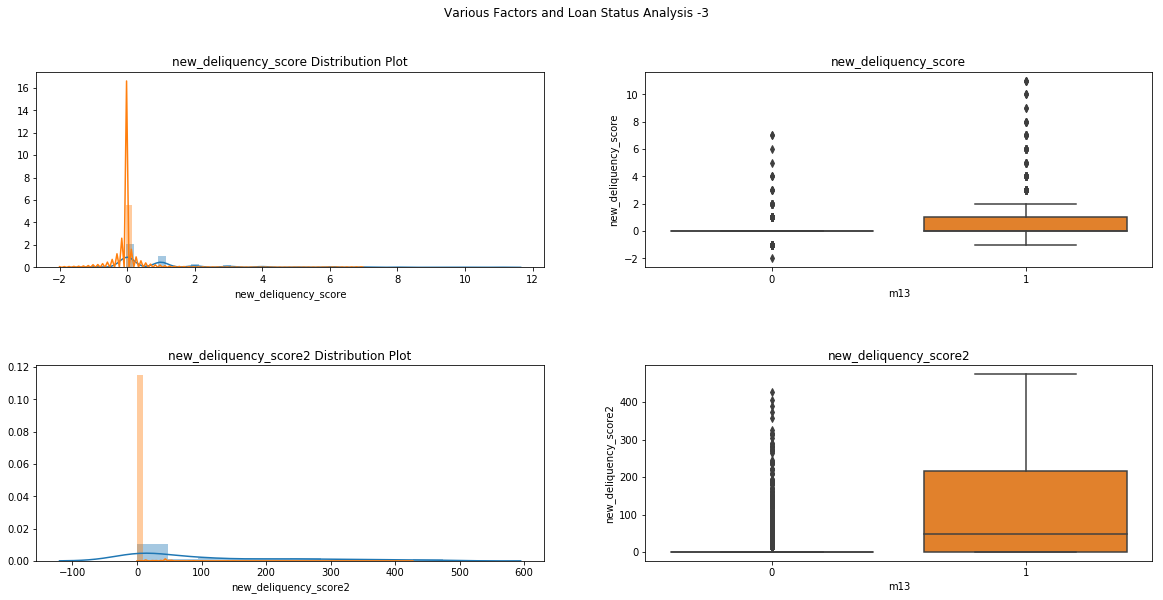

In [131]:
f, axes = plt.subplots(2, 2, figsize=(20, 9))
f.subplots_adjust(hspace=0.5)
f.suptitle('Various Factors and Loan Status Analysis -3');

axes[0,0].set(title ="new_deliquency_score Distribution Plot");
sn.distplot(loan_df[ (loan_df.m13 == 1)]['new_deliquency_score'],
            label="deliquent", ax=axes[0,0]);   # distribution of co-borrower_credit_score for defuaulted loands
sn.distplot(loan_df[(loan_df.m13 == 0) ]['new_deliquency_score'],
            label="Not Deliquent", ax=axes[0,0]) ;  #  distribution of co-borrower_credit_score for non defuaulted loands



axes[0,1].set(title ="new_deliquency_score");
sn.boxplot(data = loan_df,
            y = 'new_deliquency_score',
            x = 'm13',
            ax = axes[0,1]);


axes[1,0].set(title ="new_deliquency_score2 Distribution Plot");
sn.distplot(loan_df[ (loan_df.m13 == 1)]['new_deliquency_score2'],
            label="deliquent", ax=axes[1,0]);   # distribution of co-borrower_credit_score for defuaulted loands
sn.distplot(loan_df[(loan_df.m13 == 0) ]['new_deliquency_score2'],
            label="Not Deliquent", ax=axes[1,0]) ;  #  distribution of co-borrower_credit_score for non defuaulted loands



axes[1,1].set(title ="new_deliquency_score2");
sn.boxplot(data = loan_df,
            y = 'new_deliquency_score2',
            x = 'm13',
            ax = axes[1,1]);

We build the model with new_deliquency_score2 and check its performance.

In [133]:
varList =["interest_rate","debt_to_income_ratio", "new_cred_score","new_deliquency_score2" ]

X7 = sm.add_constant(loan_df[varList])

logit7 = sm.Logit(Y,X7);

logit7_model = logit7.fit();

logit7_model.summary2()

Optimization terminated successfully.
         Current function value: 0.021412
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                Logit              Pseudo R-squared:   0.370    
Dependent Variable:   Delquent_status    AIC:                4980.1778
Date:                 2019-08-20 20:21   BIC:                5028.4870
No. Observations:     116058             Log-Likelihood:     -2485.1  
Df Model:             4                  LL-Null:            -3945.7  
Df Residuals:         116053             LLR p-value:        0.0000   
Converged:            1.0000             Scale:              1.0000   
No. Iterations:       10.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
const                 -5.4092   0.6165  -8.7744 0.0000 -6.6174 -4.2009
interest_rate          0.7341   0.1037   7.0795 0.0000  0.5308  0.9373
debt_to_income_ratio   0.0362   0.0056   6.4391 0.0000  0.0252  0.0473
new_cred_score        -0.0060   0.0005 -11.7177 0.0000 -0.0070 -0.0050
new_deliquency_score2  0.0315   0.0009  34.4199 0.0000  0.0297  0.0333
======================================================================

"""

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.76      0.31      0.44       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.88      0.65      0.72    116058
weighted avg       0.99      1.00      0.99    116058



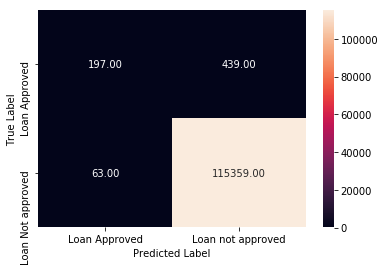

In [141]:
preicted_prob = logit7_model.predict(X7);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob": preicted_prob})

y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.5 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted))


draw_cm(y_pred_df.actual, y_pred_df.predicted)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.52      0.41      0.46       636

   micro avg       0.99      0.99      0.99    116058
   macro avg       0.76      0.70      0.73    116058
weighted avg       0.99      0.99      0.99    116058



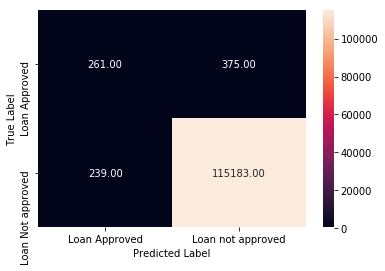

In [165]:
y_pred_df['predicted_new'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.085 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_new))
draw_cm(y_pred_df.actual, y_pred_df.predicted_new)

We notice that, given a barrowed has commited deliquency in month, probability of barrower commiting deliquency is more. We tried with two deliquency score. Deliquency score 1 showed improvement but deliquency score 2 did not add much improvement to the model. As see earlier, m1,m2, .., m12 are corelated. We derive the differences between m1 and m2, m2 and m3 etc and see if these can improve the model performance.

In [168]:
loan_df["m2_1"] = loan_df.m2 - loan_df.m1;
loan_df["m3_2"] = loan_df.m3 - loan_df.m2;
loan_df["m4_3"] = loan_df.m4 - loan_df.m3;
loan_df["m5_4"] = loan_df.m5 - loan_df.m4;
loan_df["m6_5"] = loan_df.m6 - loan_df.m5;
loan_df["m7_6"] = loan_df.m7 - loan_df.m6;
loan_df["m8_7"] = loan_df.m8 - loan_df.m7;
loan_df["m9_8"] = loan_df.m9 - loan_df.m8;
loan_df["m10_9"] = loan_df.m10 - loan_df.m9;
loan_df["m11_10"] = loan_df.m11 - loan_df.m10;
loan_df["m12_11"] = loan_df.m12 - loan_df.m11;

In [171]:
new_var =["interest_rate","debt_to_income_ratio", "new_cred_score",
          "m2_1","m3_2","m4_3","m5_4","m6_5","m7_6","m8_7","m9_8","m10_9","m11_10","m12_11"];

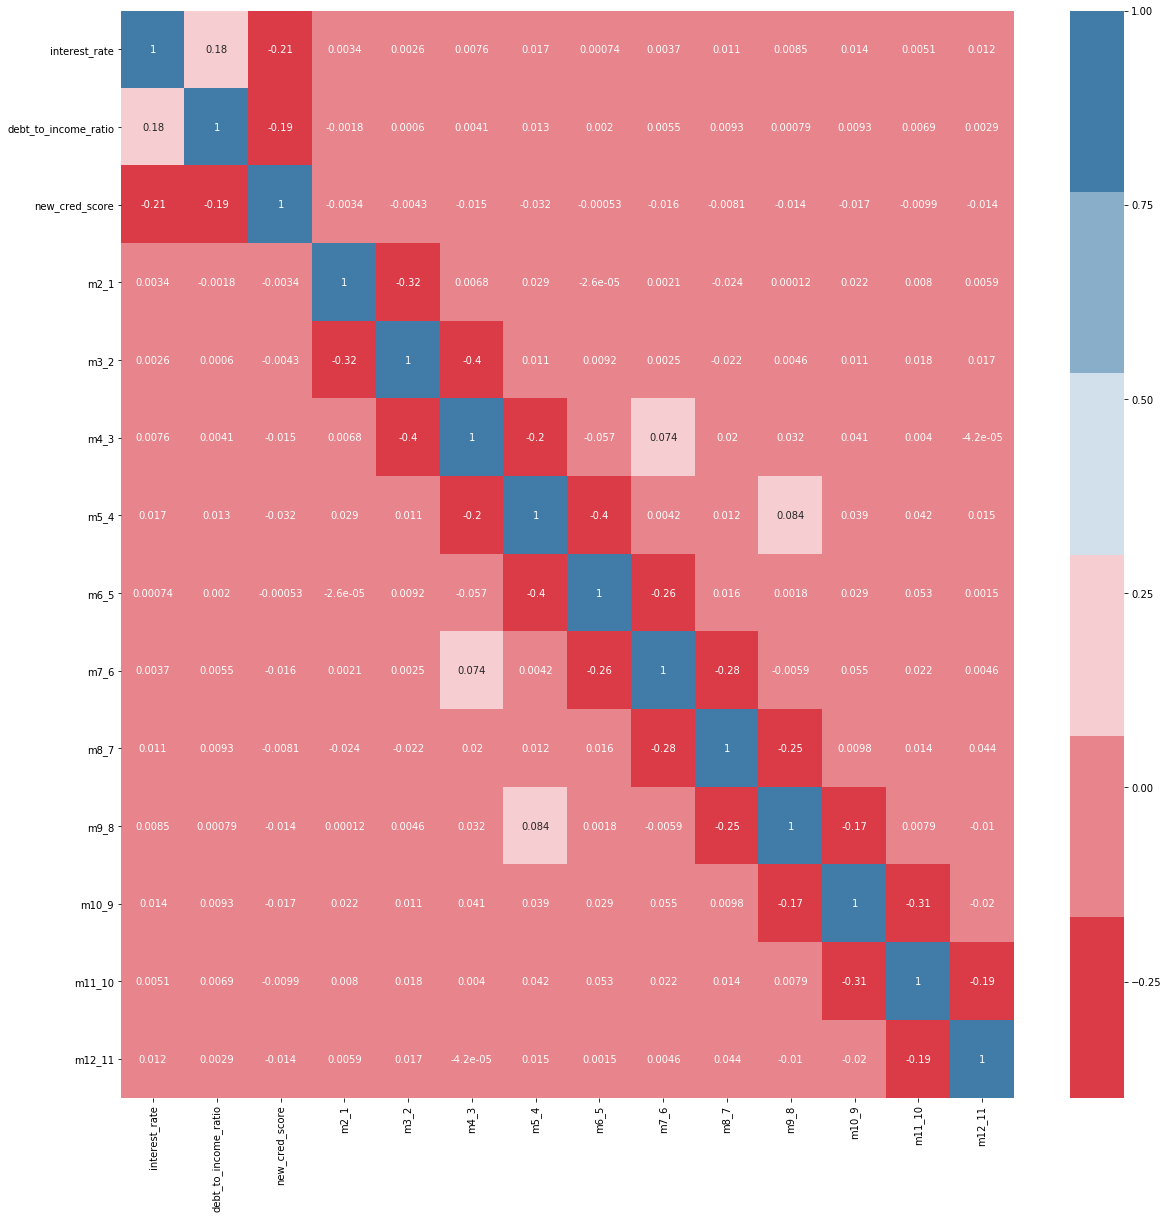

In [172]:
corr_mat = loan_df[new_var].corr();

plt.figure(figsize=(20,20))

sn.heatmap(corr_mat,
           annot = True,
          cmap = sn.diverging_palette(10,240));

We see that, there is no high corelation among the independent variables. We build the one model logistic regression and see if these variables can explain the loan_deliquency or not.

In [173]:
one_var_reg_significance3 = one_var_reg(loan_df[new_var],Y);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.032562
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033233
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032369
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033887
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032429
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033317
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032742
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032443


In [174]:
one_var_reg_significance3

,Variable,p-val in one variable regression
0,interest_rate,0.0
1,debt_to_income_ratio,0.0
2,new_cred_score,0.0
3,m2_1,0.0
4,m3_2,0.0
5,m4_3,0.0
6,m5_4,0.0
7,m6_5,0.0
8,m7_6,0.0
9,m8_7,0.0


We see that, all the variables are significant. We build the final model as below.

In [175]:
X8 = sm.add_constant(loan_df[new_var])

logit8 = sm.Logit(Y,X8);

logit8_model = logit8.fit();

logit8_model.summary2()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.022014
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                 Logit             Pseudo R-squared:  0.352    
Dependent Variable:    Delquent_status   AIC:               5139.7564
Date:                  2019-08-20 20:52  BIC:               5284.6841
No. Observations:      116058            Log-Likelihood:    -2554.9  
Df Model:              14                LL-Null:           -3945.7  
Df Residuals:          116043            LLR p-value:       0.0000   
Converged:             1.0000            Scale:             1.0000   
No. Iterations:        10.0000                                       
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -5.1428   0.5778  -8.9010 0.0000 -6.2752 -4.0104
interest_rate         0.8426   0.1016   8.2960 0.0000  0.6435  1.0416
debt_to_income_ratio  0.0383   0.0055   6.9533 0.0000  0.0275  0.0491
new_cred_score       -0.0069   0.0005 -15.0276 0.0000 -0.0078 -0.0060
m2_1                  2.2478   0.5515   4.0759 0.0000  1.1669  3.3287
m3_2                  4.2468   0.5910   7.1856 0.0000  3.0885  5.4052
m4_3                  8.6668   0.4517  19.1873 0.0000  7.7815  9.5521
m5_4                  7.2759   0.3549  20.5018 0.0000  6.5803  7.9715
m6_5                  6.4128   0.3560  18.0150 0.0000  5.7151  7.1105
m7_6                  6.0909   0.3252  18.7303 0.0000  5.4536  6.7283
m8_7                  5.4947   0.2879  19.0838 0.0000  4.9304  6.0591
m9_8                  5.6043   0.2941  19.0537 0.0000  5.0278  6.1807
m10_9                 4.6755   0.2589  18.0624 0.0000  4.1681  5.1828
m11_10                4.8731   0.2328  20.9346 0.0000  4.4169  5.3294
m12_11                4.1748   0.1459  28.6144 0.0000  3.8889  4.4608
=====================================================================

"""

We see that, every variable is significant even in the final model.

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.85      0.30      0.44       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.92      0.65      0.72    116058
weighted avg       1.00      1.00      0.99    116058



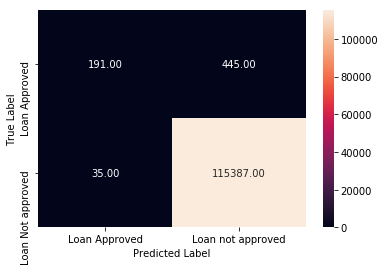

In [176]:
preicted_prob = logit8_model.predict(X8);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob": preicted_prob})

y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.5 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted))


draw_cm(y_pred_df.actual, y_pred_df.predicted)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.65      0.41      0.51       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.83      0.71      0.75    116058
weighted avg       0.99      1.00      1.00    116058



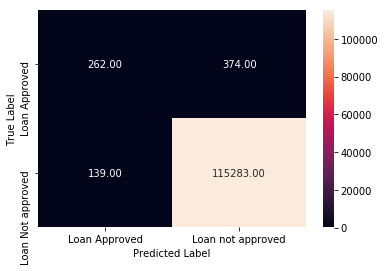

In [185]:
y_pred_df['predicted_new'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.21 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_new))
draw_cm(y_pred_df.actual, y_pred_df.predicted_new)

With this, Model did not improve well (30%, earlier f1-score was 31.52%). Now, we try to build the model with new_deliquency_score , along with differential scores.

In [186]:
new_var =["interest_rate","debt_to_income_ratio", "new_cred_score",
          "m2_1","m3_2","m4_3","m5_4","m6_5","m7_6","m8_7","m9_8","m10_9","m11_10","m12_11","new_deliquency_score"];

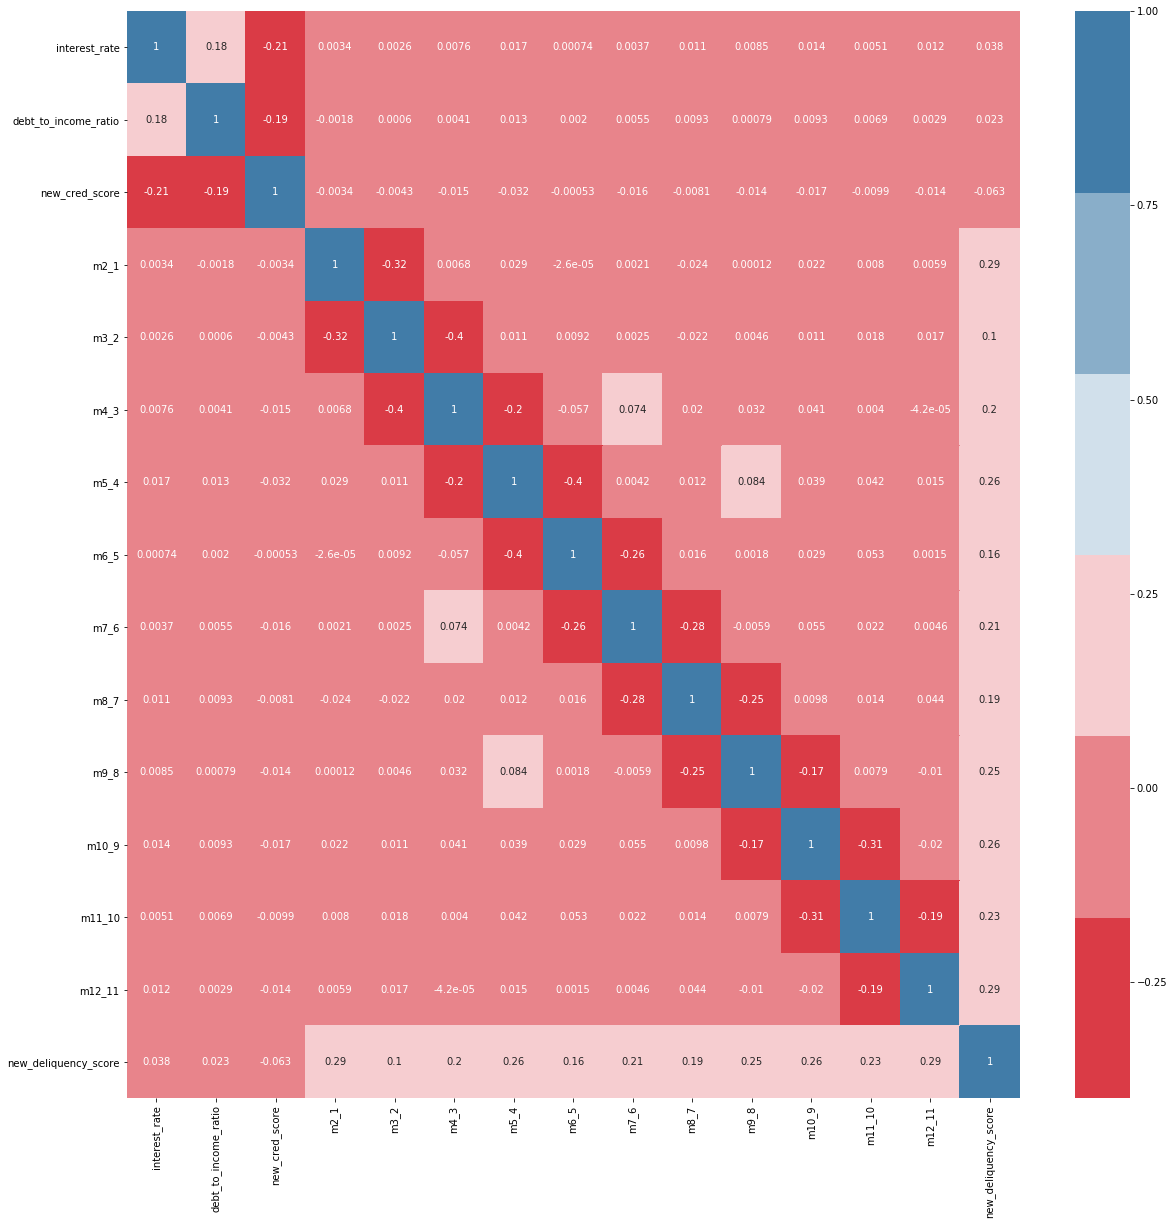

In [187]:
corr_mat = loan_df[new_var].corr();

plt.figure(figsize=(20,20))

sn.heatmap(corr_mat,
           annot = True,
          cmap = sn.diverging_palette(10,240));

In [188]:
X9 = sm.add_constant(loan_df[new_var])

logit9 = sm.Logit(Y,X9);

logit9_model = logit9.fit();

logit9_model.summary2()

Optimization terminated successfully.
         Current function value: 0.021771
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                 Logit             Pseudo R-squared:  0.360    
Dependent Variable:    Delquent_status   AIC:               5085.3673
Date:                  2019-08-20 21:14  BIC:               5239.9569
No. Observations:      116058            Log-Likelihood:    -2526.7  
Df Model:              15                LL-Null:           -3945.7  
Df Residuals:          116042            LLR p-value:       0.0000   
Converged:             1.0000            Scale:             1.0000   
No. Iterations:        10.0000                                       
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -5.2309   0.5773  -9.0613 0.0000 -6.3624 -4.0995
interest_rate         0.8558   0.1023   8.3633 0.0000  0.6553  1.0564
debt_to_income_ratio  0.0384   0.0055   6.9457 0.0000  0.0276  0.0493
new_cred_score       -0.0069   0.0005 -15.1437 0.0000 -0.0078 -0.0060
m2_1                 -1.0511   0.5922  -1.7748 0.0759 -2.2118  0.1097
m3_2                  0.7258   0.7315   0.9922 0.3211 -0.7079  2.1594
m4_3                  4.6490   0.7094   6.5536 0.0000  3.2587  6.0394
m5_4                  3.8075   0.5601   6.7981 0.0000  2.7097  4.9052
m6_5                  3.4352   0.4960   6.9261 0.0000  2.4631  4.4073
m7_6                  3.6274   0.4330   8.3765 0.0000  2.7787  4.4762
m8_7                  3.5710   0.3623   9.8556 0.0000  2.8609  4.2812
m9_8                  3.5908   0.3772   9.5209 0.0000  2.8516  4.3300
m10_9                 2.7585   0.3611   7.6395 0.0000  2.0508  3.4663
m11_10                3.1587   0.2970  10.6371 0.0000  2.5767  3.7407
m12_11                2.5194   0.2423  10.3981 0.0000  2.0445  2.9942
new_deliquency_score  1.8742   0.2337   8.0181 0.0000  1.4160  2.3323
=====================================================================

"""

As seen from the above results, we remove m2_1 and m3_2 from the model and rebuild it.

In [189]:
new_var =["interest_rate","debt_to_income_ratio", "new_cred_score",
          "m4_3","m5_4","m6_5","m7_6","m8_7","m9_8","m10_9","m11_10","m12_11","new_deliquency_score"];

In [190]:
X10 = sm.add_constant(loan_df[new_var])

logit10 = sm.Logit(Y,X10);

logit10_model = logit10.fit();

logit10_model.summary2()

Optimization terminated successfully.
         Current function value: 0.021807
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                 Logit             Pseudo R-squared:  0.359    
Dependent Variable:    Delquent_status   AIC:               5089.7694
Date:                  2019-08-20 21:16  BIC:               5225.0353
No. Observations:      116058            Log-Likelihood:    -2530.9  
Df Model:              13                LL-Null:           -3945.7  
Df Residuals:          116044            LLR p-value:       0.0000   
Converged:             1.0000            Scale:             1.0000   
No. Iterations:        10.0000                                       
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -5.2478   0.5777  -9.0839 0.0000 -6.3801 -4.1155
interest_rate         0.8542   0.1021   8.3680 0.0000  0.6541  1.0543
debt_to_income_ratio  0.0389   0.0055   7.0390 0.0000  0.0281  0.0497
new_cred_score       -0.0069   0.0005 -15.0458 0.0000 -0.0078 -0.0060
m4_3                  4.5724   0.5462   8.3713 0.0000  3.5019  5.6429
m5_4                  3.7397   0.4340   8.6175 0.0000  2.8891  4.5902
m6_5                  3.5383   0.3784   9.3501 0.0000  2.7966  4.2800
m7_6                  3.6829   0.3161  11.6508 0.0000  3.0634  4.3025
m8_7                  3.6193   0.2417  14.9775 0.0000  3.1457  4.0930
m9_8                  3.6725   0.2747  13.3714 0.0000  3.1342  4.2108
m10_9                 2.8590   0.2766  10.3352 0.0000  2.3168  3.4012
m11_10                3.2261   0.2373  13.5933 0.0000  2.7610  3.6913
m12_11                2.5877   0.1867  13.8639 0.0000  2.2219  2.9536
new_deliquency_score  1.8016   0.1488  12.1060 0.0000  1.5100  2.0933
=====================================================================

"""

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.85      0.29      0.44       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.92      0.65      0.72    116058
weighted avg       1.00      1.00      0.99    116058



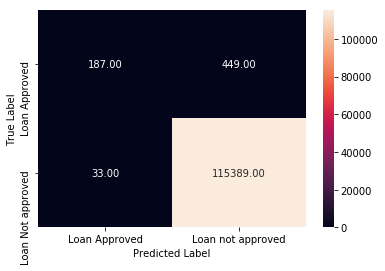

In [192]:
preicted_prob = logit10_model.predict(X10);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob": preicted_prob})

y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.5 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted))


draw_cm(y_pred_df.actual, y_pred_df.predicted)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.54      0.47      0.50       636

   micro avg       0.99      0.99      0.99    116058
   macro avg       0.77      0.73      0.75    116058
weighted avg       0.99      0.99      0.99    116058



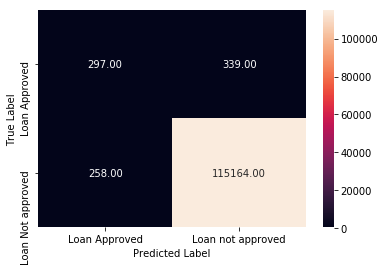

In [202]:
y_pred_df['predicted_new'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.085 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_new))
draw_cm(y_pred_df.actual, y_pred_df.predicted_new)

We see that, now the model f1-score is 28% on test data. From our observations, Model 6 with new deliquency score(which indicates how many times a person deliquented/improved).

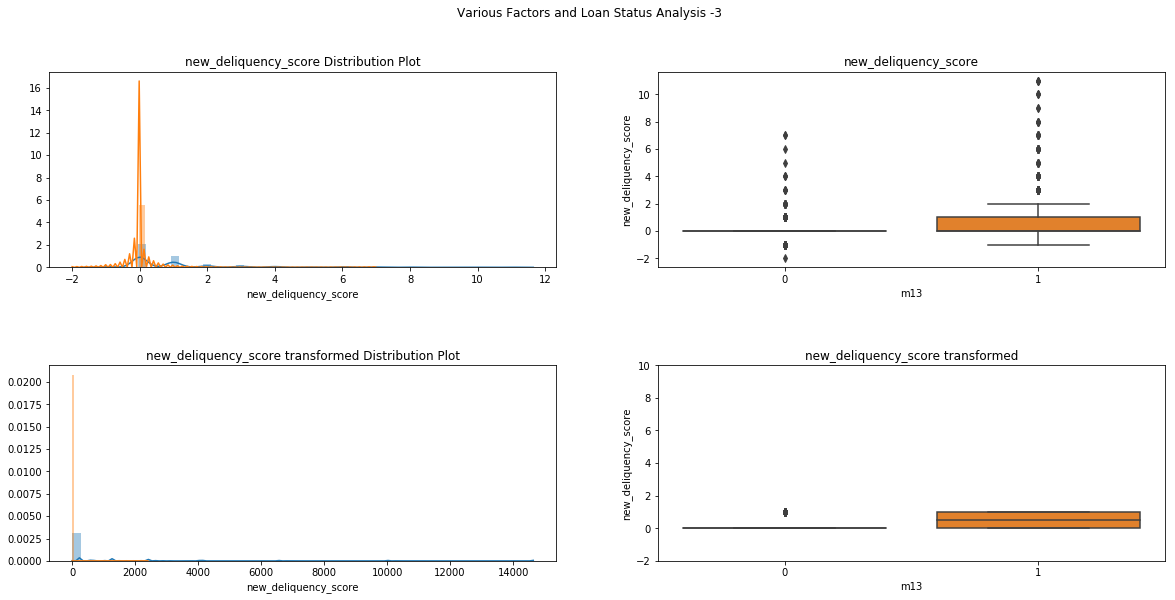

In [219]:
f, axes = plt.subplots(2, 2, figsize=(20, 9))
f.subplots_adjust(hspace=0.5)
f.suptitle('Various Factors and Loan Status Analysis -3');

axes[0,0].set(title ="new_deliquency_score Distribution Plot");
sn.distplot(loan_df[ (loan_df.m13 == 1)]['new_deliquency_score'],
            label="deliquent", ax=axes[0,0]);   # distribution of co-borrower_credit_score for defuaulted loands
sn.distplot(loan_df[(loan_df.m13 == 0) ]['new_deliquency_score'],
            label="Not Deliquent", ax=axes[0,0]) ;  #  distribution of co-borrower_credit_score for non defuaulted loands



axes[0,1].set(title ="new_deliquency_score");
sn.boxplot(data = loan_df,
            y = 'new_deliquency_score',
            x = 'm13',
            ax = axes[0,1]);


axes[1,0].set(title ="new_deliquency_score transformed Distribution Plot");
sn.distplot(np.power(loan_df[ (loan_df.m13 == 1)]['new_deliquency_score'],4),
            label="deliquent", ax=axes[1,0]);   # distribution of co-borrower_credit_score for defuaulted loands
sn.distplot(np.power(loan_df[(loan_df.m13 == 0) ]['new_deliquency_score'] ,4),
            label="Not Deliquent", ax=axes[1,0]) ;  #  distribution of co-borrower_credit_score for non defuaulted loands



axes[1,1].set(title ="new_deliquency_score transformed");
sn.boxplot(
            y=np.power(loan_df['new_deliquency_score'],4),
           x=loan_df['m13'],
            ax = axes[1,1]);

axes[1,1].set(ylim=(-2, 10));

In [217]:
np.power(2,4)

16

In [221]:
loan_df[ (loan_df.m13 == 1) & (loan_df.new_deliquency_score == 0 )].m13.count()

318

In [222]:
loan_df[ (loan_df.m13 == 1) & (loan_df.new_deliquency_score > 0 )].m13.count()

305

In [9]:
loan_df[ (loan_df.m13 == 1) & (loan_df.m12 == 0 )].m13.count()

336

In [10]:
loan_df[ (loan_df.m13 == 1) & (loan_df.m12 > 0 )].m13.count()

300

In [223]:
loan_df[ (loan_df.m13 == 0) & (loan_df.new_deliquency_score == 0 )].m13.count()

114902

In [225]:
loan_df[ (loan_df.m13 == 0) & (loan_df.new_deliquency_score > 0 )].m13.count()

250

In [226]:
loan_df[ (loan_df.m13 == 1) & (loan_df.new_deliquency_score2 > 0 )].m13.count()

403

In [227]:
loan_df[ (loan_df.m13 == 0) & (loan_df.new_deliquency_score2 > 0 )].m13.count()

1608

In [228]:
new_var =["interest_rate","debt_to_income_ratio", "new_cred_score",
          "m4_3","m5_4","m6_5","m7_6","m8_7","m9_8","m10_9","m11_10","m12_11","new_deliquency_score"];

In [231]:
loan_df["isDebtToIncomeHigh"] = loan_df.debt_to_income_ratio.map(lambda x: 1 if x>=30 else 0);

In [248]:
new_var =["interest_rate","debt_to_income_ratio", "new_cred_score","new_deliquency_score"];

Optimization terminated successfully.
         Current function value: 0.022970
         Iterations 10
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.56      0.46      0.50       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.78      0.73      0.75    116058
weighted avg       0.99      1.00      0.99    116058



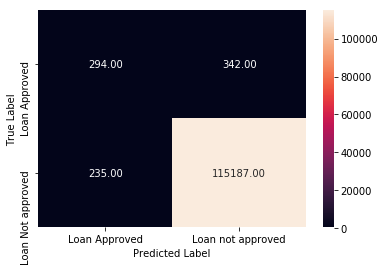

In [249]:
X11 = sm.add_constant(loan_df[new_var])

logit11 = sm.Logit(Y,X11);

logit11_model = logit11.fit();

logit11_model.summary2()

preicted_prob = logit11_model.predict(X11);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob": preicted_prob})

y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.1 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted))


draw_cm(y_pred_df.actual, y_pred_df.predicted)

In [48]:
del_count = loan_df.m13.map(lambda x: 1 if x>0 else 0).sum();

def fun(x):
    if x>0:
        return 1;
    else:
        return 0;
        

del_prob =[];

del_prob.append(["m1",round(loan_df[loan_df.m1 >0].m2.map(fun).sum()/loan_df.m1.map(fun).sum()*100,2)]);
del_prob.append(["m2",round(loan_df[loan_df.m2 >0].m3.map(fun).sum()/loan_df.m2.map(fun).sum()*100,2)]);
del_prob.append(["m3",round(loan_df[loan_df.m3 >0].m4.map(fun).sum()/loan_df.m3.map(fun).sum()*100,2)]);
del_prob.append(["m4",round(loan_df[loan_df.m4 >0].m5.map(fun).sum()/loan_df.m4.map(fun).sum()*100,2)]);
del_prob.append(["m5",round(loan_df[loan_df.m5 >0].m6.map(fun).sum()/loan_df.m5.map(fun).sum()*100,2)]);
del_prob.append(["m6",round(loan_df[loan_df.m6 >0].m7.map(fun).sum()/loan_df.m6.map(fun).sum()*100,2)]);
del_prob.append(["m7",round(loan_df[loan_df.m7 >0].m8.map(fun).sum()/loan_df.m7.map(fun).sum()*100,2)]);
del_prob.append(["m8",round(loan_df[loan_df.m8 >0].m9.map(fun).sum()/loan_df.m8.map(fun).sum()*100,2)]);
del_prob.append(["m9",round(loan_df[loan_df.m9 >0].m10.map(fun).sum()/loan_df.m9.map(fun).sum()*100,2)]);
del_prob.append(["m10",round(loan_df[loan_df.m10 >0].m1.map(fun).sum()/loan_df.m10.map(fun).sum()*100,2)]);
del_prob.append(["m11",round(loan_df[loan_df.m11 >0].m12.map(fun).sum()/loan_df.m11.map(fun).sum()*100,2)]);
del_prob.append(["m12",round(loan_df[loan_df.m12 >0].m13.map(fun).sum()/loan_df.m12.map(fun).sum()*100,2)]);


del_prob_df = pd.DataFrame(del_prob, columns =["Month", "Prob"])


In [49]:
del_prob_df

,Month,Prob
0,m1,14.89
1,m2,28.04
2,m3,32.63
3,m4,48.99
4,m5,35.95
5,m6,48.35
6,m7,50.91
7,m8,52.49
8,m9,54.99
9,m10,7.64


In [47]:
round(loan_df[loan_df.m8 >0].m12.map(fun).sum()/loan_df[loan_df.m8 >0].m8.count()*100,2)

40.88

In [1]:
new_var =["interest_rate","debt_to_income_ratio", "new_cred_score","m12"];

In [13]:
X11 = sm.add_constant(loan_df[new_var])

logit11 = sm.Logit(Y,X11);

logit11_model = logit11.fit();

logit11_model.summary2()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.021522
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                 Logit             Pseudo R-squared:  0.367    
Dependent Variable:    Delquent_status   AIC:               5005.5165
Date:                  2019-08-21 20:29  BIC:               5053.8258
No. Observations:      116058            Log-Likelihood:    -2497.8  
Df Model:              4                 LL-Null:           -3945.7  
Df Residuals:          116053            LLR p-value:       0.0000   
Converged:             1.0000            Scale:             1.0000   
No. Iterations:        10.0000                                       
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -5.2076   0.5757  -9.0457 0.0000 -6.3360 -4.0792
interest_rate         0.8184   0.1028   7.9606 0.0000  0.6169  1.0199
debt_to_income_ratio  0.0391   0.0055   7.0702 0.0000  0.0283  0.0499
new_cred_score       -0.0068   0.0005 -15.0763 0.0000 -0.0077 -0.0059
m12                   4.8941   0.1236  39.5942 0.0000  4.6518  5.1364
=====================================================================

"""

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.79      0.31      0.44       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.89      0.65      0.72    116058
weighted avg       1.00      1.00      0.99    116058



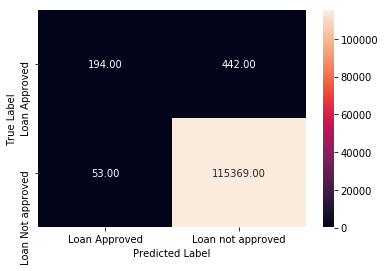

In [18]:
preicted_prob = logit11_model.predict(X11);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob": preicted_prob})

y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.5 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted))


draw_cm(y_pred_df.actual, y_pred_df.predicted)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.55      0.47      0.51       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.77      0.73      0.75    116058
weighted avg       0.99      1.00      0.99    116058



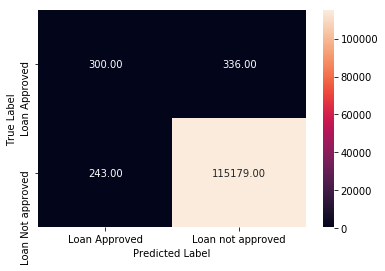

In [51]:
y_pred_df['predicted_new'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.085 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_new))
draw_cm(y_pred_df.actual, y_pred_df.predicted_new)

In [52]:
loan_df["new_deliquency_score_final"] =    ((loan_df.m2- loan_df.m1).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m3- loan_df.m2).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m4- loan_df.m3).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m5- loan_df.m4).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m6- loan_df.m5).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m7- loan_df.m6).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m8- loan_df.m7).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m9- loan_df.m8).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m10- loan_df.m9).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m11- loan_df.m10).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                    + (loan_df.m12- loan_df.m11).map(lambda x: 1 if x>0 else (0 if x<0 else 0)) 
                                     );

In [53]:
new_var =["interest_rate","debt_to_income_ratio", "new_cred_score","new_deliquency_score_final"];

In [54]:
X13 = sm.add_constant(loan_df[new_var])

logit13 = sm.Logit(Y,X13);

logit13_model = logit13.fit();

logit13_model.summary2()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.021586
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                   Logit               Pseudo R-squared:    0.365    
Dependent Variable:      Delquent_status     AIC:                 5020.5652
Date:                    2019-08-21 21:04    BIC:                 5068.8744
No. Observations:        116058              Log-Likelihood:      -2505.3  
Df Model:                4                   LL-Null:             -3945.7  
Df Residuals:            116053              LLR p-value:         0.0000   
Converged:               1.0000              Scale:               1.0000   
No. Iterations:          10.0000                                           
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
const                      -5.5927   0.6252  -8.9459 0.0000 -6.8180 -4.3674
interest_rate               0.7398   0.1018   7.2648 0.0000  0.5402  0.9394
debt_to_income_ratio        0.0392   0.0056   7.0689 0.0000  0.0284  0.0501
new_cred_score             -0.0059   0.0005 -11.2406 0.0000 -0.0070 -0.0049
new_deliquency_score_final  2.1601   0.0571  37.8089 0.0000  2.0481  2.2721
===========================================================================

"""

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.71      0.27      0.39       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.85      0.63      0.69    116058
weighted avg       0.99      1.00      0.99    116058



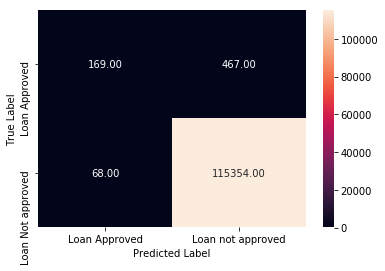

In [55]:
preicted_prob = logit13_model.predict(X13);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob": preicted_prob})

y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.5 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted))


draw_cm(y_pred_df.actual, y_pred_df.predicted)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.50      0.42      0.46       636

   micro avg       0.99      0.99      0.99    116058
   macro avg       0.75      0.71      0.73    116058
weighted avg       0.99      0.99      0.99    116058



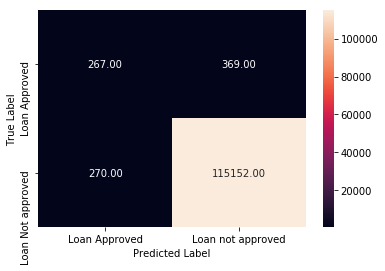

In [64]:
y_pred_df['predicted_new'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.09 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_new))
draw_cm(y_pred_df.actual, y_pred_df.predicted_new)

In [66]:
loan_df["log_unpaid_bal"] = np.log(loan_df.unpaid_principal_bal);

In [71]:
new_var =["interest_rate","log_unpaid_bal", "debt_to_income_ratio", "new_cred_score","new_deliquency_score"];

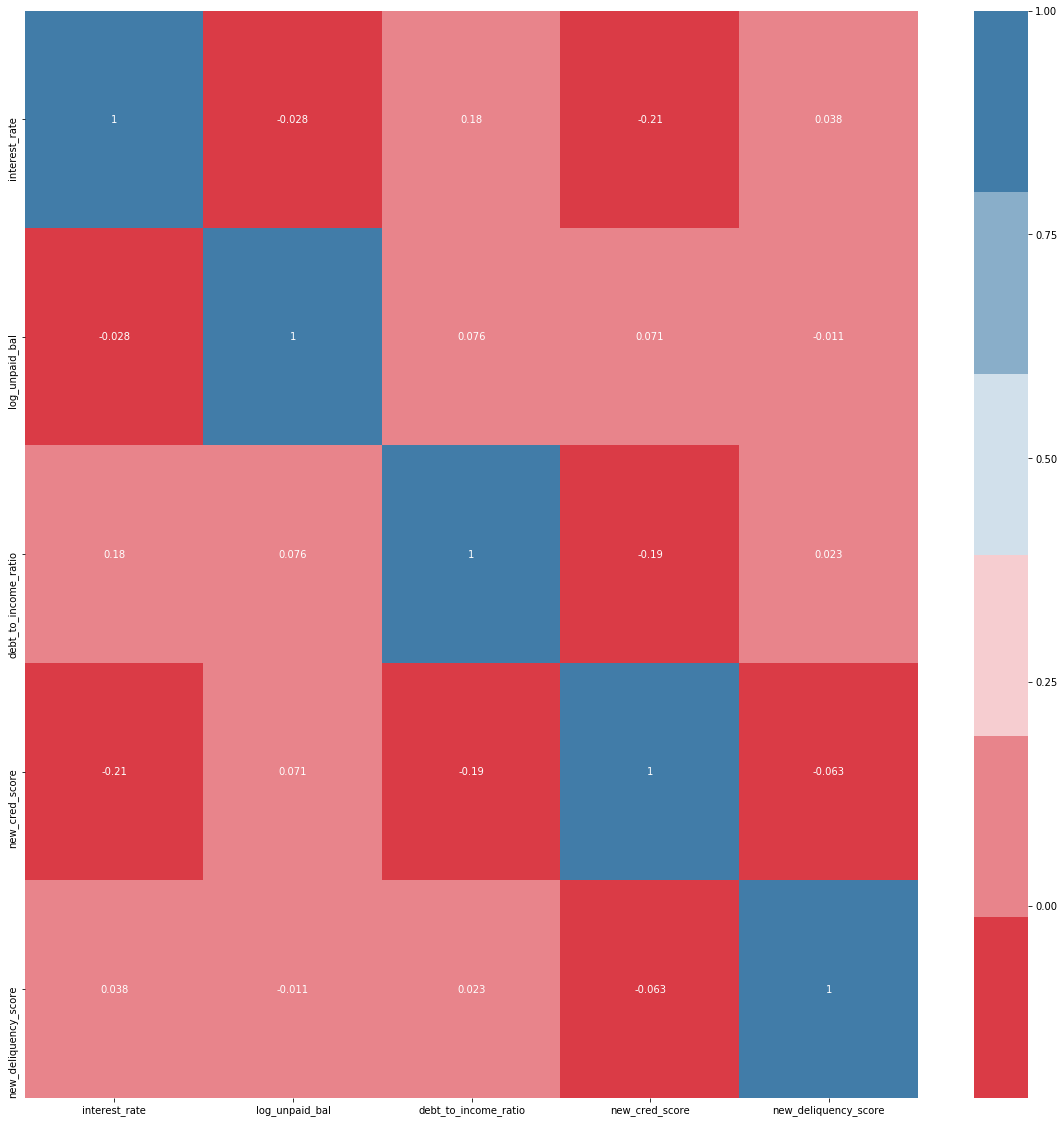

In [72]:
corr_mat = loan_df[new_var].corr();

plt.figure(figsize=(20,20))

sn.heatmap(corr_mat,
           annot = True,
          cmap = sn.diverging_palette(10,240));

In [73]:
X14 = sm.add_constant(loan_df[new_var])

logit14 = sm.Logit(Y,X14);

logit14_model = logit14.fit();

logit14_model.summary2()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.022869
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                 Logit             Pseudo R-squared:  0.327    
Dependent Variable:    Delquent_status   AIC:               5320.2478
Date:                  2019-08-21 21:47  BIC:               5378.2189
No. Observations:      116058            Log-Likelihood:    -2654.1  
Df Model:              5                 LL-Null:           -3945.7  
Df Residuals:          116052            LLR p-value:       0.0000   
Converged:             1.0000            Scale:             1.0000   
No. Iterations:        10.0000                                       
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -1.7869   1.1469  -1.5580 0.1192 -4.0348  0.4610
interest_rate         0.8141   0.0990   8.2245 0.0000  0.6201  1.0081
log_unpaid_bal       -0.2784   0.0784  -3.5527 0.0004 -0.4320 -0.1248
debt_to_income_ratio  0.0405   0.0054   7.4539 0.0000  0.0299  0.0512
new_cred_score       -0.0068   0.0005 -14.6463 0.0000 -0.0077 -0.0059
new_deliquency_score  3.7397   0.1228  30.4535 0.0000  3.4990  3.9804
=====================================================================

"""

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.84      0.24      0.38       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.92      0.62      0.69    116058
weighted avg       1.00      1.00      0.99    116058



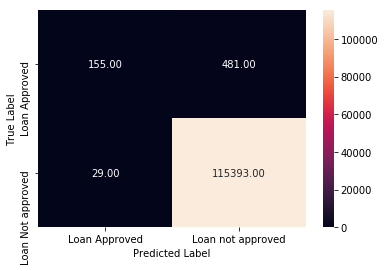

In [74]:
preicted_prob = logit14_model.predict(X14);

y_pred_df = pd.DataFrame({"actual": Y.Delquent_status, "predicted_prob": preicted_prob})

y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.5 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted))


draw_cm(y_pred_df.actual, y_pred_df.predicted)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    115422
        True       0.56      0.46      0.51       636

   micro avg       1.00      1.00      1.00    116058
   macro avg       0.78      0.73      0.75    116058
weighted avg       0.99      1.00      0.99    116058



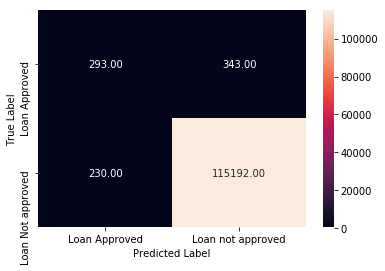

In [81]:
y_pred_df['predicted_new'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.1 else 0)
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_new))
draw_cm(y_pred_df.actual, y_pred_df.predicted_new)